#### Assignment: Deep Learning, Programming Assignment

1. Implement the Sparse auto-encoder and the Contractive Auto-encoder. Use the MNIST digit dataset for
training your network. Use the U-Net auto-encoder architecture for encoder and decoder without skip
connections. Let E be the trained encoder and D be the trained decoder, h = E(I) be the embedding of
an image I and let ˆI = D(h) be the output of the decoder.
- (20 points) Plot the t-sne (use inbuilt function) on the embeddings obtained using the respective
auto-encoders. Color the clusters using the respective ground-truth class labels.
- (20 points) Randomly take two images I1 and I2 from two different digit classes. Let h1 = E(I1)
and h2 = E(I2) be the embeddings for these images, respectively....
- (20 points) After training the autoencoders, you want to check if the embeddings of different digits
are different and embeddings within a class are similar. For this purpose, you propose to perform
the classification of the digits based on the embeddings obtained by the encoders and check the
accuracy of classifications for each of the Auto-encoder. Report the classification accuracy for each
of the AE and report which one is better. Use any inbuilt classifier to solve the classification
problem

In [21]:
%pip install tensorflow numpy matplotlib scikit-learn seaborn tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns 
from sklearn.metrics import mean_squared_error
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [23]:
# Set random seed for reproducibility
tf.random.set_seed(42)
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(
            f"Found {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU instead")
if gpus:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled")

TensorFlow version: 2.18.0
No GPU found, using CPU instead


In [24]:
# Hyperparameters
batch_size = 128
epochs = 2
learning_rate = 0.001
sparse_lambda = 1e-3  # Sparsity penalty
contractive_lambda = 1e-4  # Contractive penalty
rho = 0.05  # Target sparsity
epsilon = 1e-6

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

U-net: 
- https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/
- https://towardsdatascience.com/understanding-u-net-61276b10f360/

In [25]:
# U-Net-like Encoder
def build_encoder():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    z = layers.Dense(128)(x)
    return models.Model(inputs, z, name='encoder')


In [26]:
def build_decoder():
    inputs = layers.Input(shape=(128,))
    x = layers.Dense(256 * 3 * 3, activation='relu')(inputs)
    x = layers.Reshape((3, 3, 256))(x)
    x = layers.Conv2DTranspose(
        128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(
        64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(
        1, 3, strides=2, padding='same', activation='sigmoid')(x)
    x = layers.Conv2D(1, 3, padding='valid',
                      activation='sigmoid')(x)
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(x)
    return models.Model(inputs, x, name='decoder')

Sparse Encoder
- https://www.geeksforgeeks.org/deep-learning/sparse-autoencoders-in-deep-learning/
- https://www.geeksforgeeks.org/machine-learning/auto-encoders/

In [27]:
# Sparse Autoencoder
class SparseAutoencoder(models.Model):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, input_images):
        encoded_features = self.encoder(input_images)
        reconstructed_images = self.decoder(encoded_features)
        return reconstructed_images, encoded_features

In [28]:

def sparse_ae_loss(y_true, y_pred, z):
    mse_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
    rho_hat = tf.reduce_mean(z, axis=0)
    rho_hat = tf.clip_by_value(rho_hat, epsilon, 1 - epsilon)
    kl_div = rho * tf.math.log(rho / rho_hat) + \
        (1 - rho) * tf.math.log((1 - rho) / (1 - rho_hat))
    # Clip KL term
    kl_loss = sparse_lambda * tf.reduce_sum(
        tf.clip_by_value(kl_div, -1e4, 1e4))
    return mse_loss + kl_loss

Contractive Autoencoder
- https://www.geeksforgeeks.org/deep-learning/contractive-autoencoder-cae/
- https://medium.com/aimonks/contractive-autoencoders-an-insight-into-enhanced-feature-learning-d3d3bd103d88

In [29]:
class ContractiveAutoencoder(models.Model):
    def __init__(self):
        super(ContractiveAutoencoder, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, input_images):
        encoded_features = self.encoder(input_images)
        reconstructed_images = self.decoder(encoded_features)
        return reconstructed_images, encoded_features

In [30]:
def contractive_ae_loss(x, recon, z, model):
    mse_loss = tf.reduce_mean(tf.square(x - recon))
    with tf.GradientTape() as tape:
        tape.watch(z)
        recon = model.decoder(z)
    grad_z = tape.gradient(recon, z)
    j_loss = contractive_lambda * tf.reduce_mean(
        tf.reduce_sum(tf.square(grad_z), axis=1))
    return mse_loss + j_loss

In [31]:
def train(autoencoder_model, training_dataset, loss_function, num_epochs, learning_rate, model_type='sparse'):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for current_epoch in range(num_epochs):
        epoch_total_loss = 0
        for training_batch in training_dataset:
            with tf.GradientTape() as gradient_tape:
                reconstructed_images, encoded_features = autoencoder_model(
                    training_batch)
                if model_type == 'sparse':
                    current_loss = loss_function(
                        training_batch, reconstructed_images, encoded_features)
                else:
                    current_loss = loss_function(
                        training_batch, reconstructed_images, encoded_features, autoencoder_model)
            computed_gradients = gradient_tape.gradient(
                current_loss, autoencoder_model.trainable_variables)
            optimizer.apply_gradients(
                zip(computed_gradients, autoencoder_model.trainable_variables))
            epoch_total_loss += current_loss.numpy()
        print(
            f'Epoch {current_epoch + 1}/{num_epochs}, {model_type.capitalize()} AE Loss: {epoch_total_loss / len(training_dataset): .6f}')

In [32]:
sparse_ae = SparseAutoencoder()
contractive_ae = ContractiveAutoencoder()

print("Training Sparse Autoencoder...")
train(sparse_ae, train_dataset, sparse_ae_loss, epochs, learning_rate, 'sparse')

print("\nTraining Contractive Autoencoder...")
train(contractive_ae, train_dataset, contractive_ae_loss,
      epochs, learning_rate, 'contractive')

Training Sparse Autoencoder...
Epoch 1/2, Sparse AE Loss:  0.080353
Epoch 2/2, Sparse AE Loss:  0.040826

Training Contractive Autoencoder...
Epoch 1/2, Contractive AE Loss:  0.121675
Epoch 2/2, Contractive AE Loss:  0.099177


In [33]:
def reconstruct_and_validate(model, dataset, model_name, num_images=5):
    for batch in dataset.take(1):
        images, label = batch
        original_images = images.numpy()
        recon_images, _ = model(original_images, training=False)
        recon_images = recon_images.numpy()

    # Compute MSE for the batch
    mse = np.mean((original_images - recon_images) ** 2)
    print(f"{model_name} Test MSE: {mse:.6f}")

    # Visualize original and reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original {i + 1}")
        plt.axis('off')
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Reconstructed {i + 1}")
        plt.axis('off')
    plt.suptitle(f"{model_name} Reconstruction")
    plt.tight_layout()    
    plt.show()
    plt.close()

Sparse Autoencoder...
Sparse Autoencoder Test MSE: 0.020553


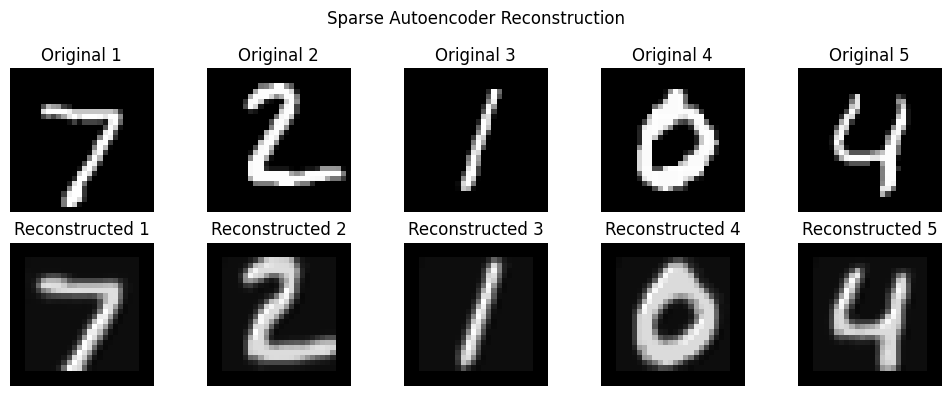

Contractive Autoencoder...
Contractive Autoencoder Test MSE: 0.089604


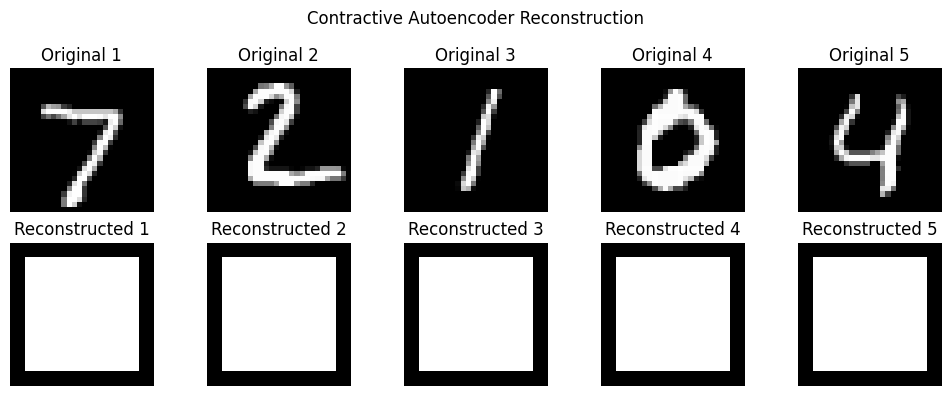

In [34]:
print("Sparse Autoencoder...")
reconstruct_and_validate(sparse_ae, test_dataset, "Sparse Autoencoder")

print("Contractive Autoencoder...")
reconstruct_and_validate(
    contractive_ae, test_dataset, "Contractive Autoencoder")

T-SNE
- https://www.geeksforgeeks.org/machine-learning/ml-t-distributed-stochastic-neighbor-embedding-t-sne-algorithm/
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow

In [35]:
def plot_tsne_embeddings(model, dataset, model_name, num_samples=1000):
    embeddings = []
    labels = []
    for batch_images, batch_labels in dataset.take(num_samples // batch_size + 1):
        z = model.encoder(batch_images, training=False).numpy()
        embeddings.append(z)
        labels.append(batch_labels.numpy())
    embeddings = np.concatenate(embeddings, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    # Apply t-SNE to reduce to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Plot t-SNE with colors for each class
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=labels,
                    palette='tab10', legend='full', s=50)
    plt.title(f"t-SNE of {model_name} Embeddings (MNIST Classes)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Digit", loc="best")
    plt.tight_layout()    
    plt.show()
    plt.close()


Sparse Autoencoder...


e:\AI\ai-ml-course\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


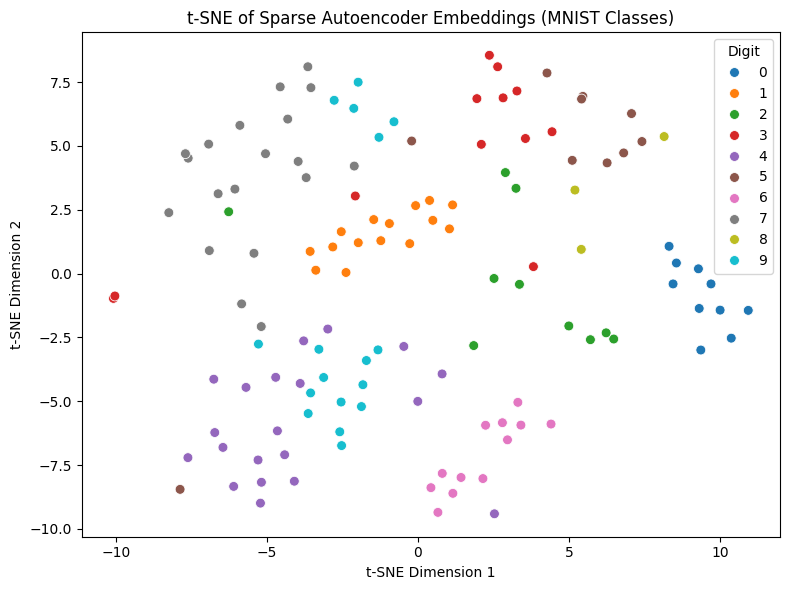

Contractive Autoencoder...


e:\AI\ai-ml-course\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


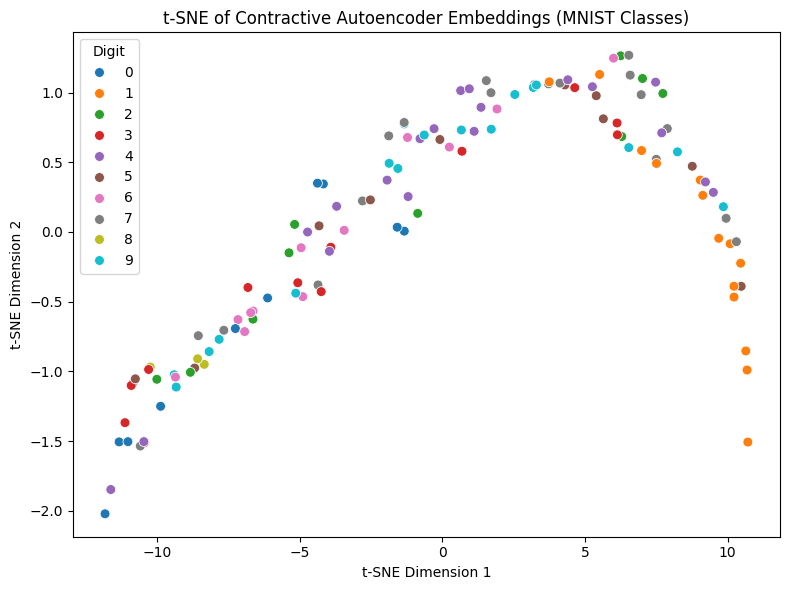

In [36]:
print("Sparse Autoencoder...")
plot_tsne_embeddings(sparse_ae, test_dataset, "Sparse Autoencoder", batch_size)

print("Contractive Autoencoder...")
plot_tsne_embeddings(contractive_ae, test_dataset,"Contractive Autoencoder", batch_size)

- https://www.geeksforgeeks.org/python/python-peak-signal-to-noise-ratio-psnr/
- https://stackoverflow.com/questions/55844618/how-to-calculate-psnr-metric-in-keras

In [37]:
def compute_psnr(img1, img2, max_val=1.0):
    mse = mean_squared_error(img1.flatten(), img2.flatten())
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse))

In [38]:
def interpolation_analysis(model, dataset, model_name, num_pairs=20, num_images_per_pair=5):
    all_test_images, all_test_labels = [], []
    for batch_images, batch_labels in dataset:
        all_test_images.append(batch_images.numpy())
        all_test_labels.append(batch_labels.numpy())
    all_test_images = np.concatenate(all_test_images, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)

    np.random.seed(42)
    image_indices = np.arange(len(all_test_labels))
    np.random.shuffle(image_indices)
    selected_image_pairs = []
    used_label_pairs = set()
    current_index = 0

    while len(selected_image_pairs) < num_pairs and current_index < len(image_indices):
        first_image_idx = image_indices[current_index]
        first_label = all_test_labels[first_image_idx]

        for next_index in range(current_index + 1, len(image_indices)):
            second_image_idx = image_indices[next_index]
            second_label = all_test_labels[second_image_idx]

            if first_label != second_label and (first_label, second_label) not in used_label_pairs:
                selected_image_pairs.append(
                    (first_image_idx, second_image_idx))
                used_label_pairs.add((first_label, second_label))
                break
        current_index += 1

    interpolation_alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    psnr_metrics = {alpha: [] for alpha in interpolation_alphas}
    l2_norm_metrics = {alpha: [] for alpha in interpolation_alphas}

    for pair_index, (first_idx, second_idx) in enumerate(selected_image_pairs[:num_pairs]):
        first_image = all_test_images[first_idx:first_idx + 1]
        second_image = all_test_images[second_idx:second_idx + 1]
        first_digit_label, second_digit_label = all_test_labels[
            first_idx], all_test_labels[second_idx]

        first_embedding = model.encoder(first_image, training=False).numpy()
        second_embedding = model.encoder(second_image, training=False).numpy()

        plt.figure(figsize=(12, len(interpolation_alphas) * 2))

        for alpha_index, alpha_weight in enumerate(interpolation_alphas):
            interpolated_image = alpha_weight * \
                first_image + (1 - alpha_weight) * second_image

            interpolated_embedding = model.encoder(
                interpolated_image, training=False).numpy()

            interpolated_embedding_direct = alpha_weight * \
                first_embedding + (1 - alpha_weight) * second_embedding

            reconstructed_from_interpolated = model.decoder(
                interpolated_embedding, training=False).numpy()
            reconstructed_from_direct = model.decoder(
                interpolated_embedding_direct, training=False).numpy()

            psnr_value = compute_psnr(
                reconstructed_from_interpolated[0], reconstructed_from_direct[0])
            l2_distance = np.sqrt(
                np.sum((interpolated_embedding - interpolated_embedding_direct) ** 2))

            psnr_metrics[alpha_weight].append(psnr_value)
            l2_norm_metrics[alpha_weight].append(l2_distance)

            plt.subplot(len(interpolation_alphas), 2, alpha_index * 2 + 1)
            plt.imshow(reconstructed_from_interpolated[0].reshape(
                28, 28), cmap='gray')
            plt.title(f"Îα (α={alpha_weight:.1f})")
            plt.axis('off')

            plt.subplot(len(interpolation_alphas), 2, alpha_index * 2 + 2)
            plt.imshow(reconstructed_from_direct[0].reshape(
                28, 28), cmap='gray')
            plt.title(f"Î′α (α={alpha_weight:.1f})")
            plt.axis('off')

        plt.suptitle(
            f"{model_name} Pair {pair_index + 1}: Digit {first_digit_label} to {second_digit_label}")
        plt.tight_layout()
        plt.show()
        plt.close()

    # Print summary metrics
    print(f"\n{model_name} Metrics:")
    print("Alpha | Avg PSNR (dB) | Avg L2 Norm")
    print("------|---------------|------------")
    for alpha_weight in interpolation_alphas:
        average_psnr = np.mean(psnr_metrics[alpha_weight])
        average_l2_norm = np.mean(l2_norm_metrics[alpha_weight])
        print(f"{alpha_weight:.1f}  | {average_psnr:.4f}      | {average_l2_norm:.4f}")

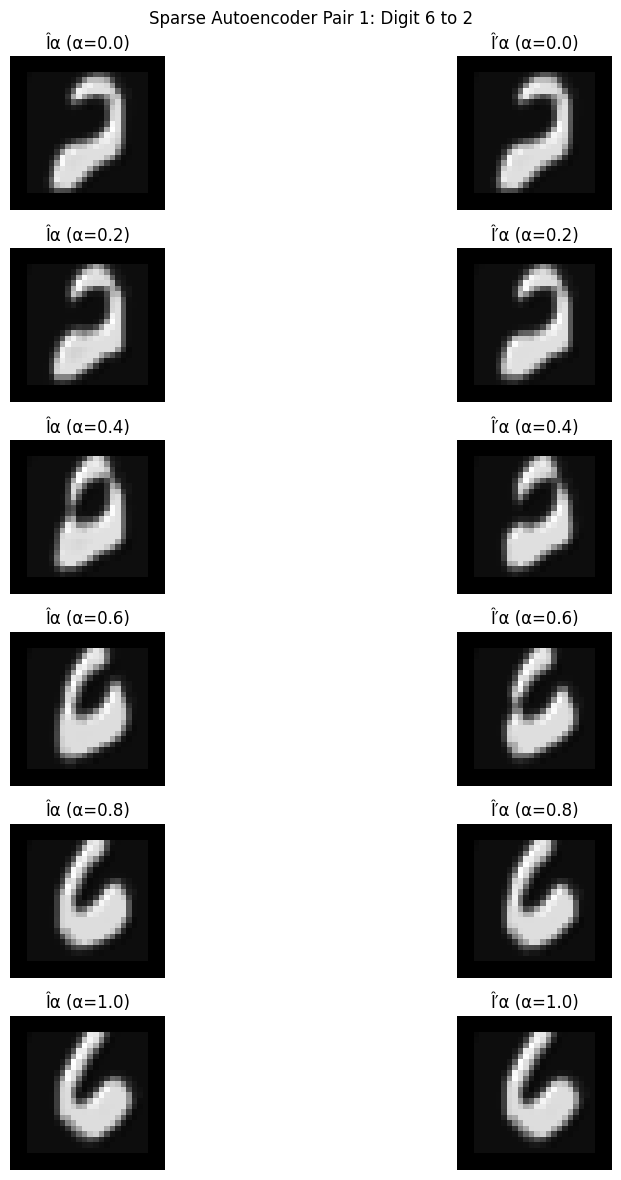

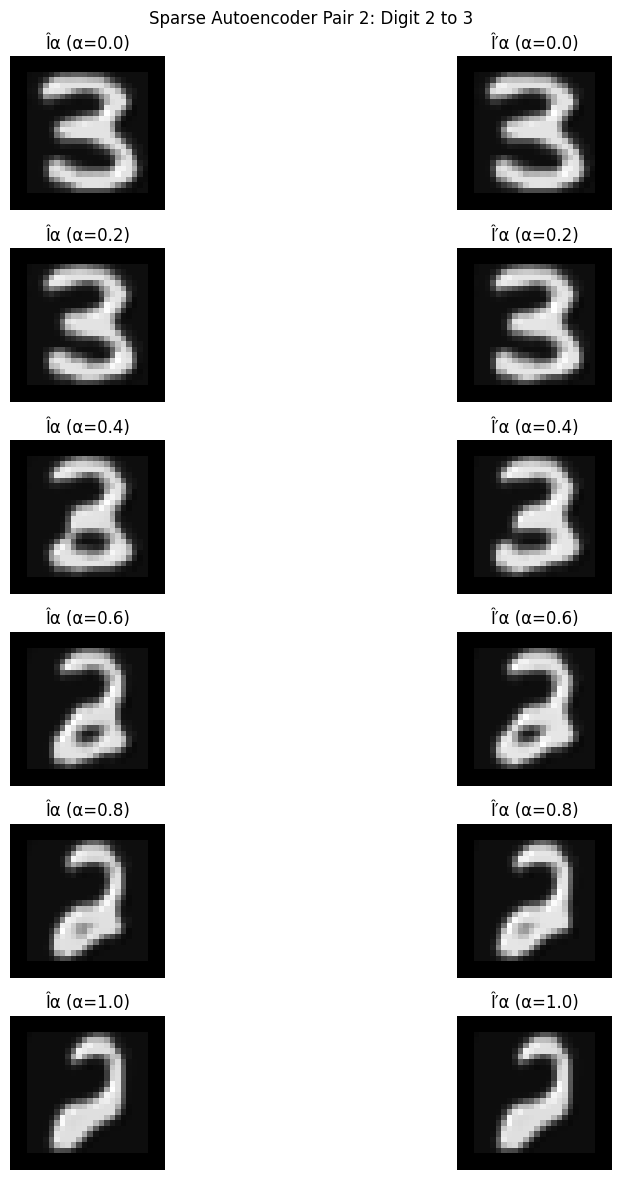

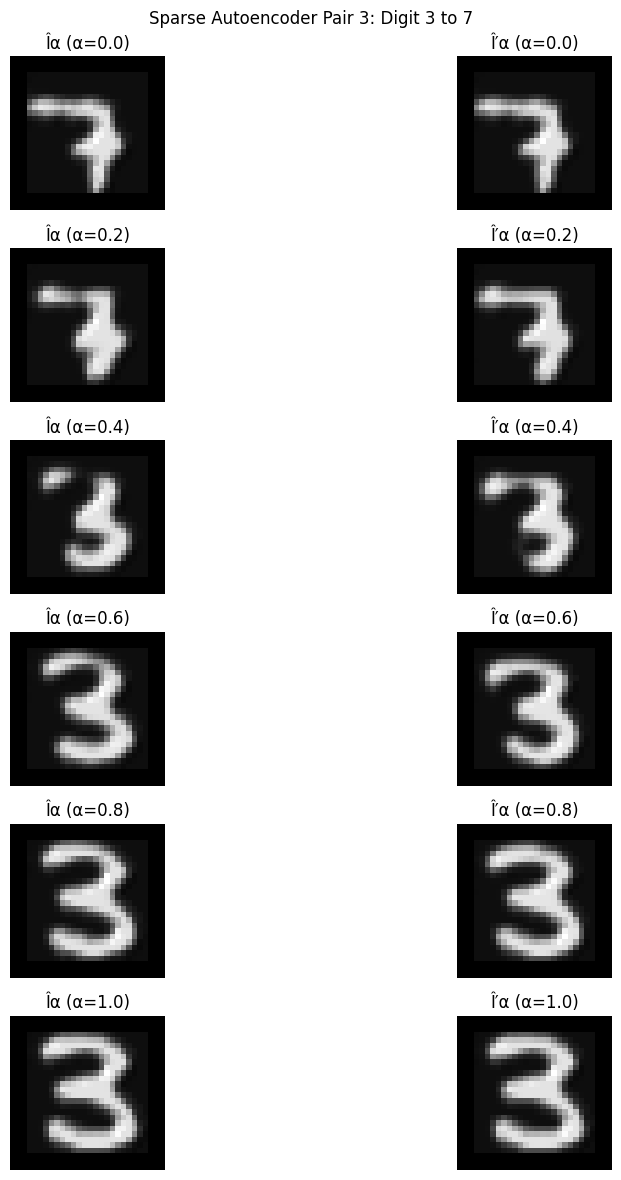

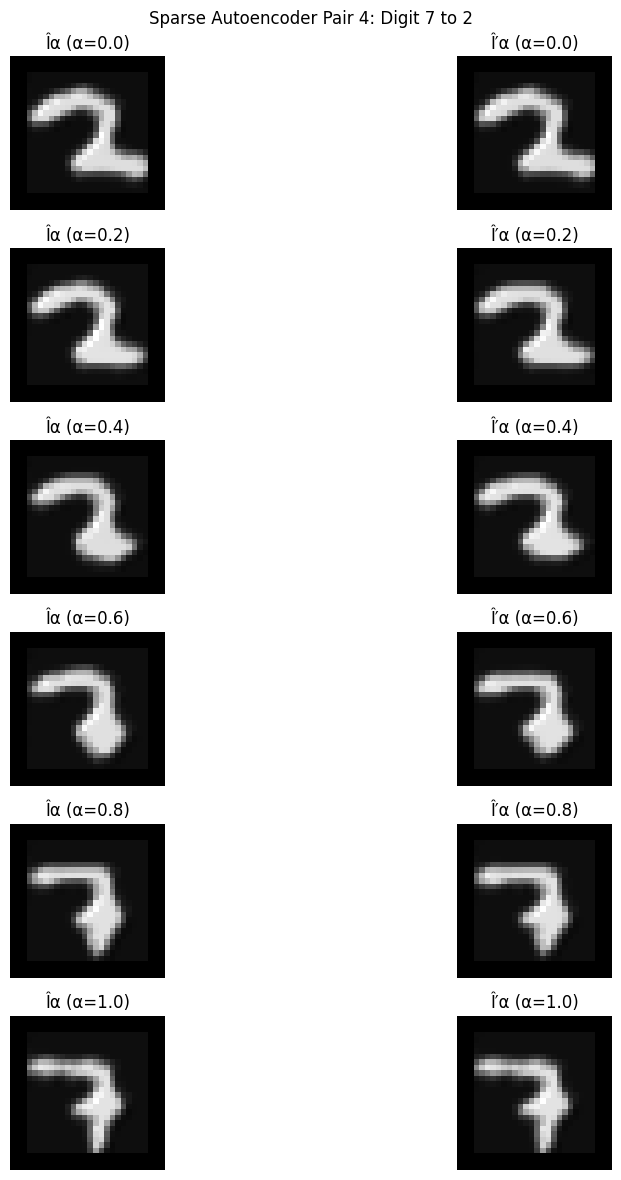

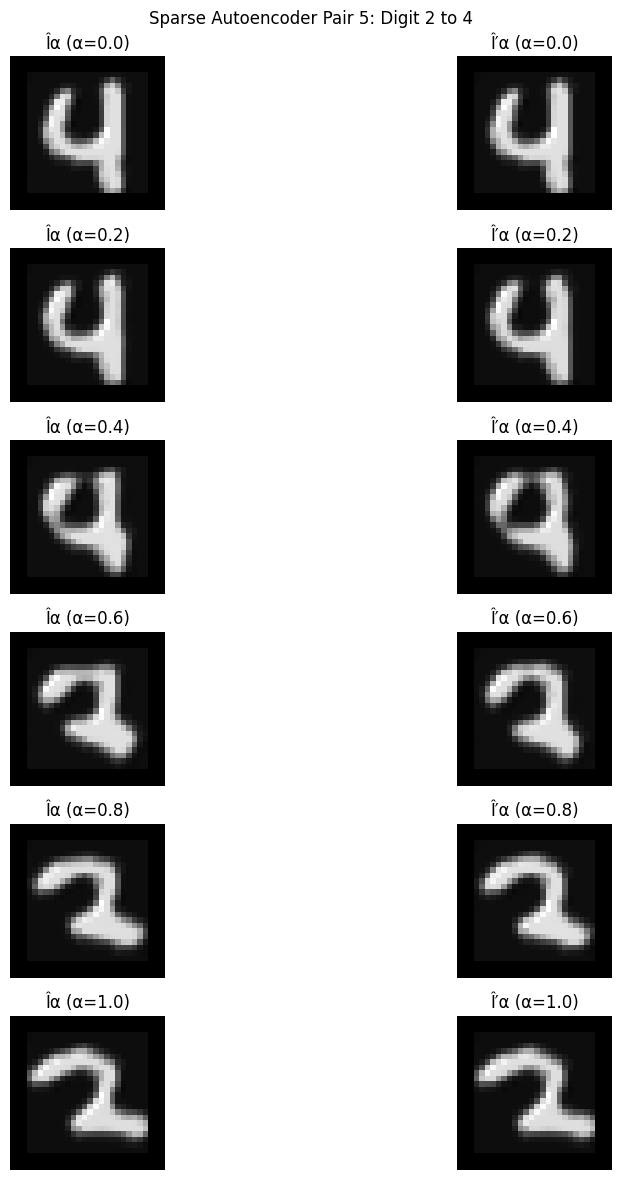

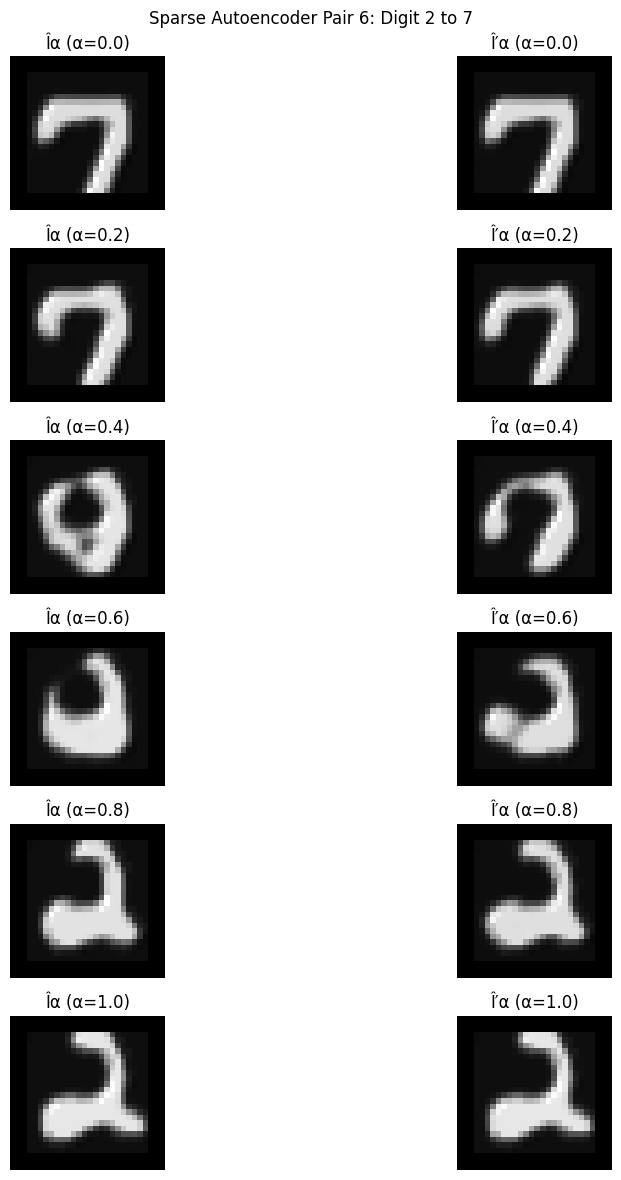

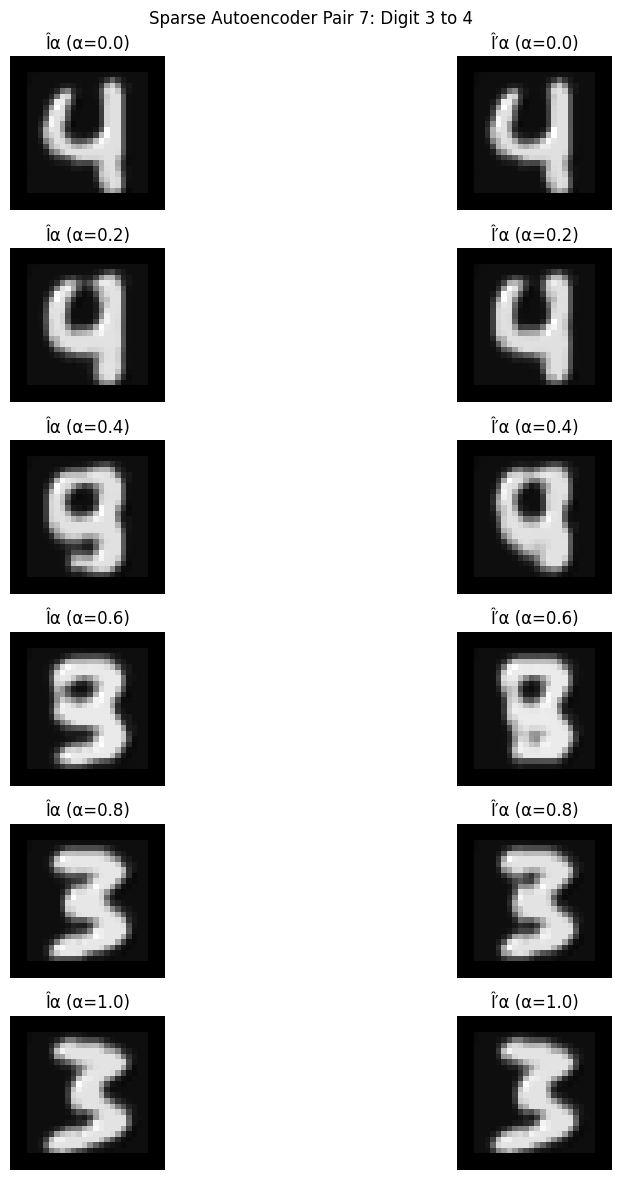

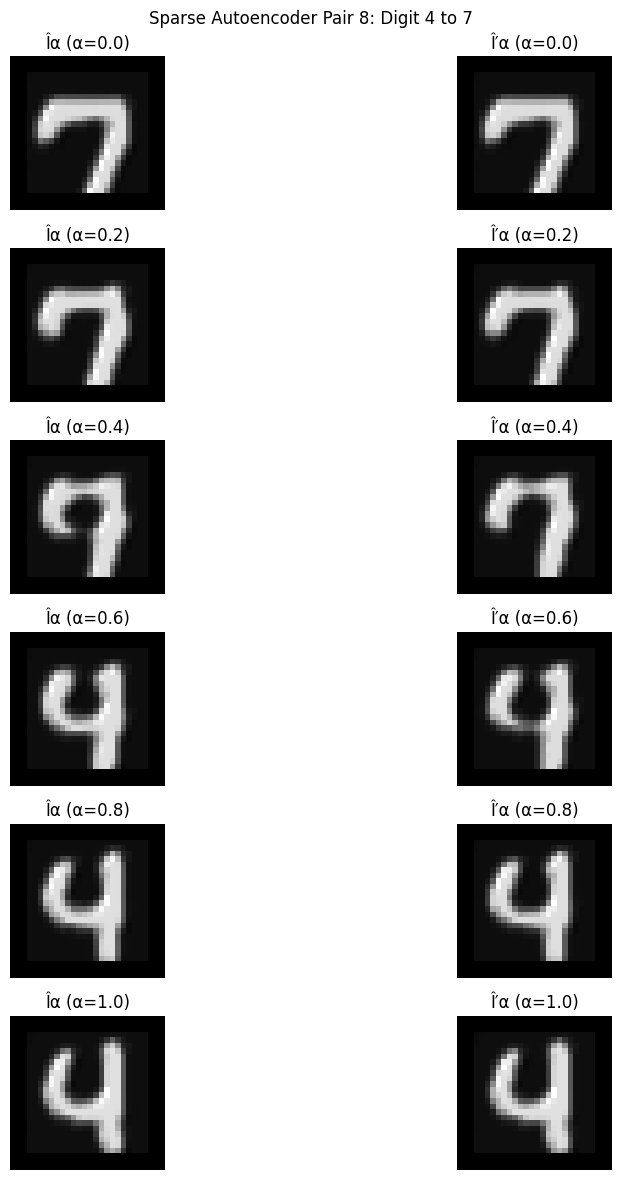

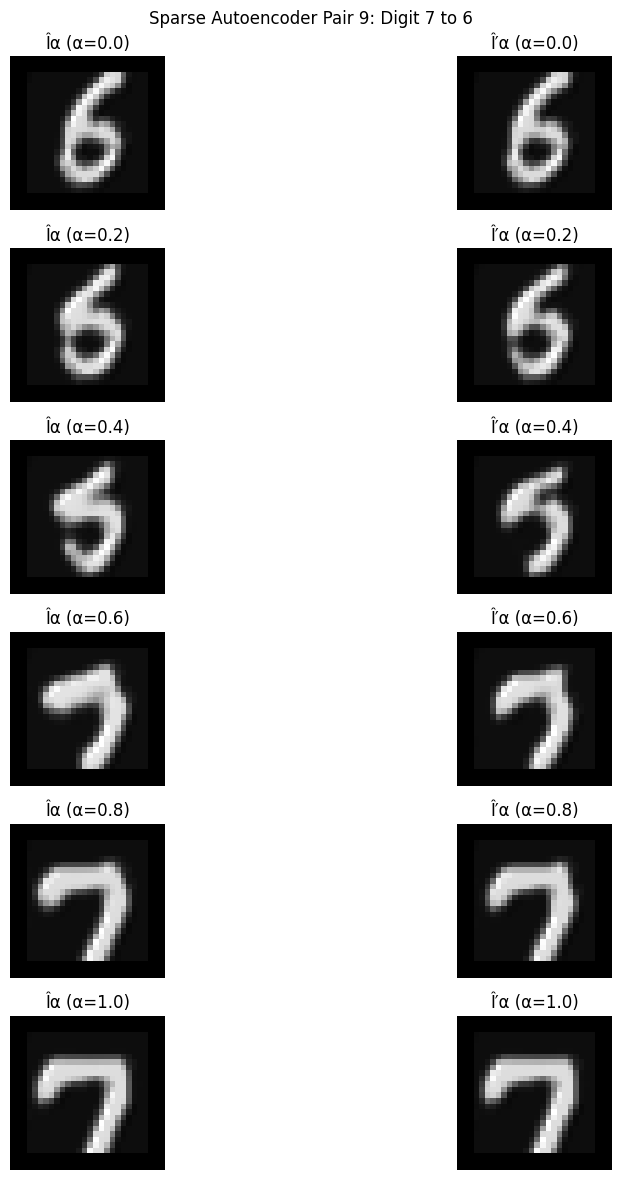

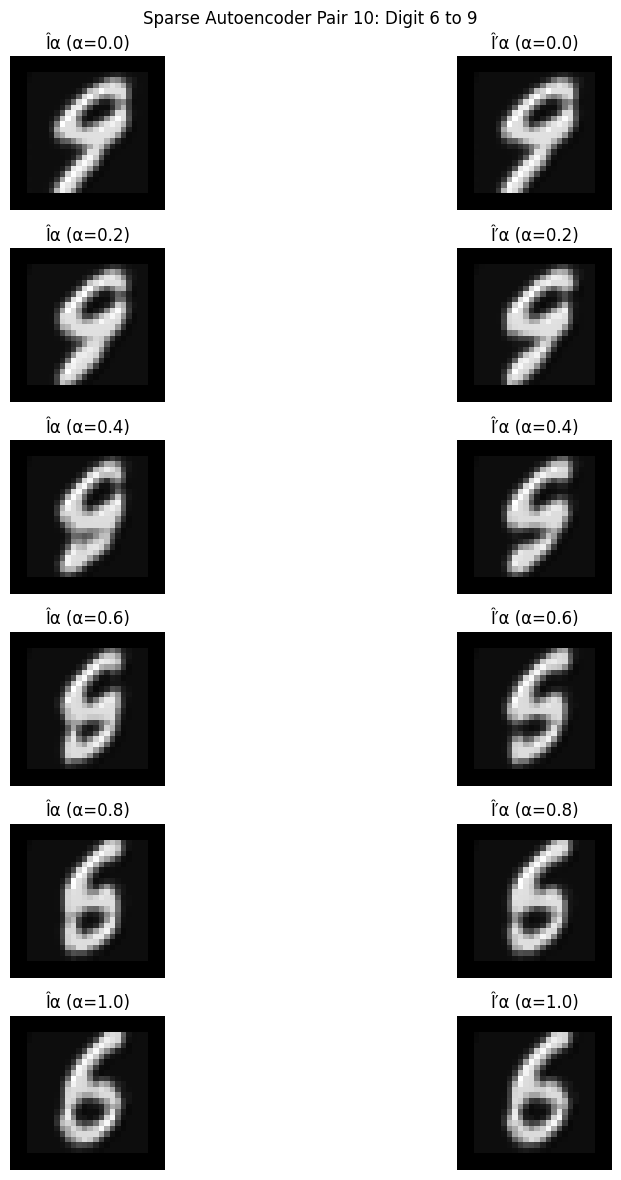

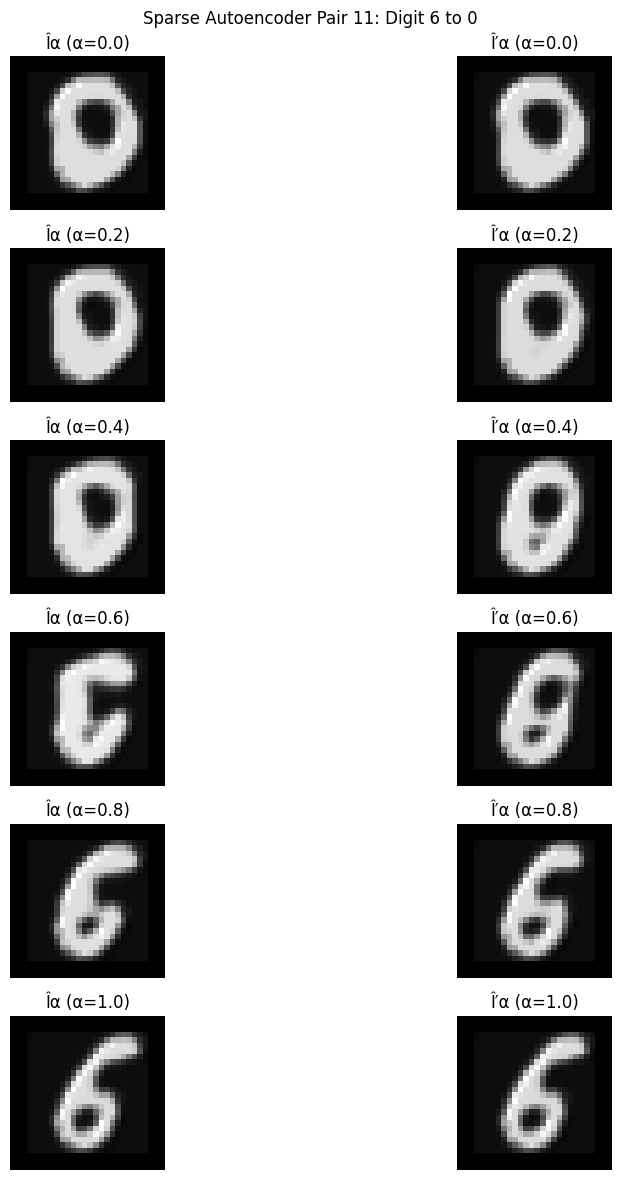

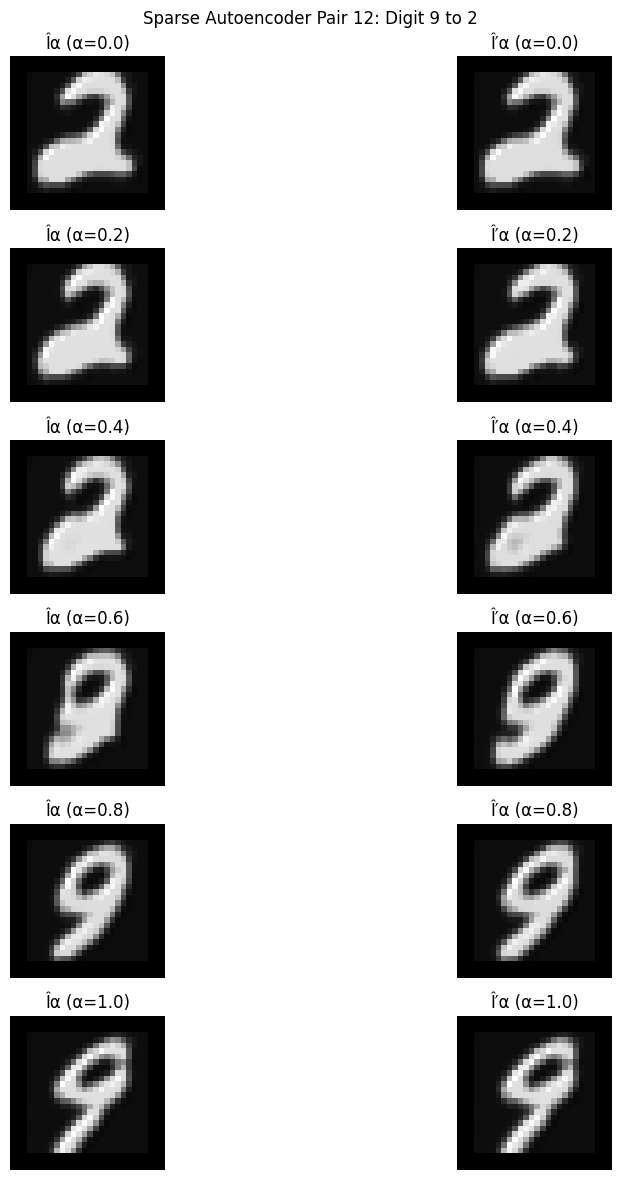

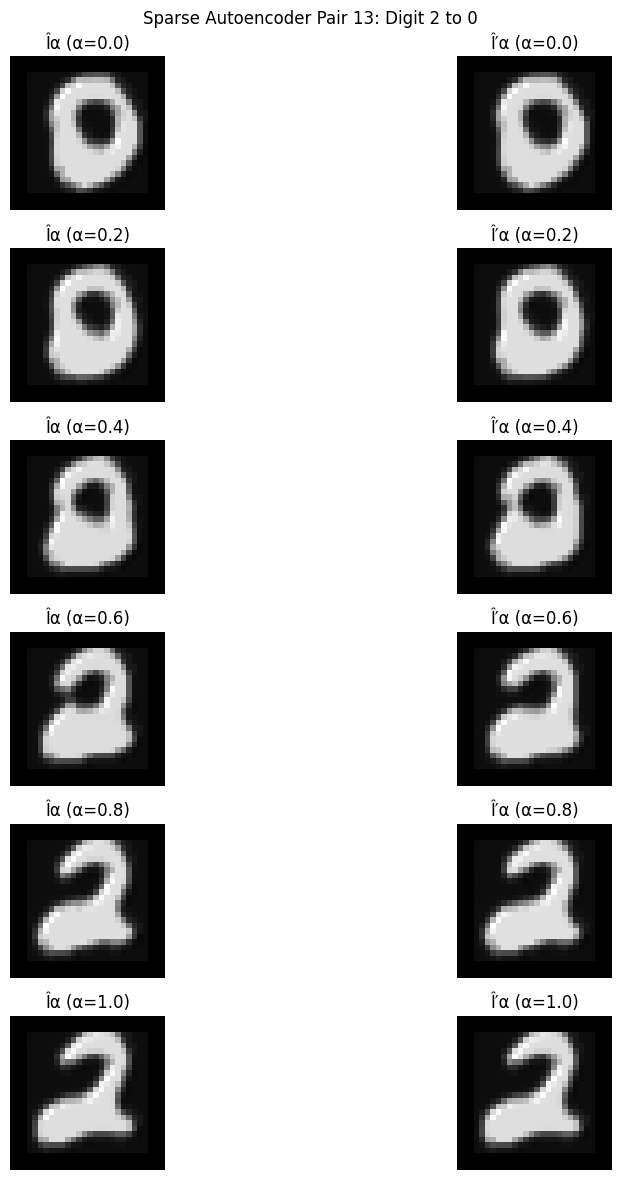

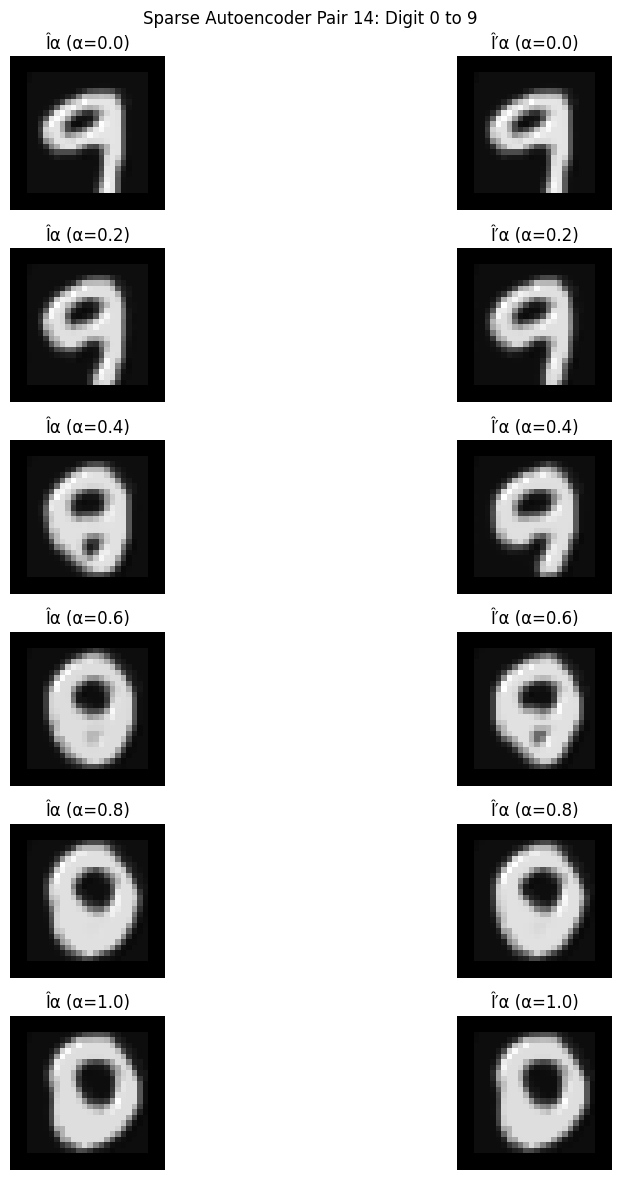

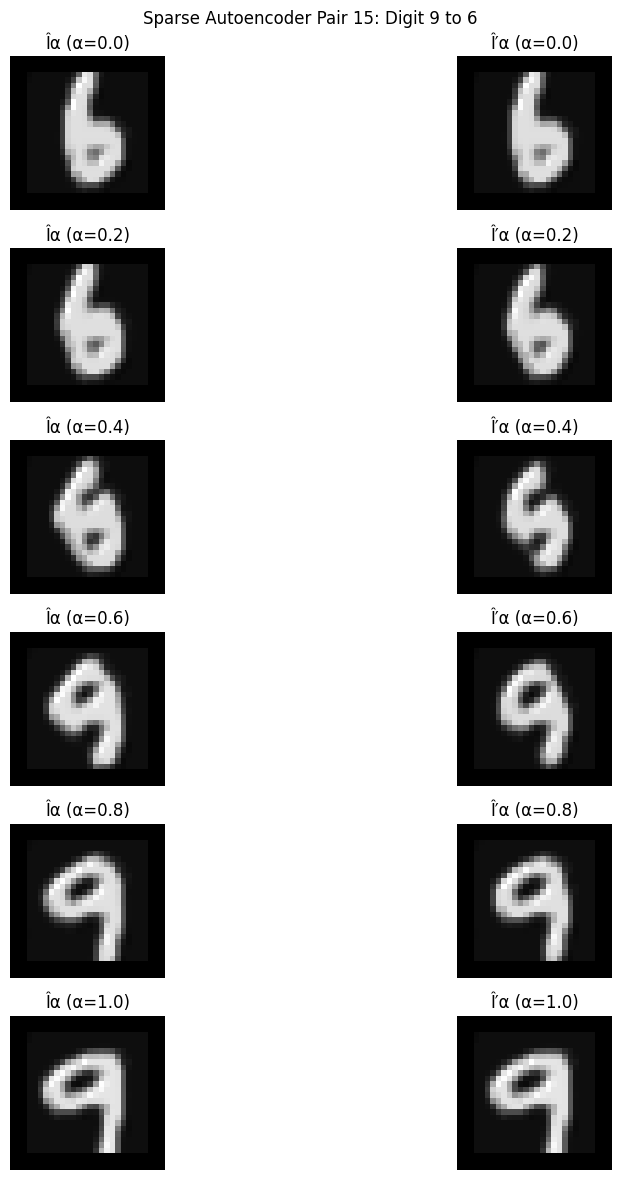

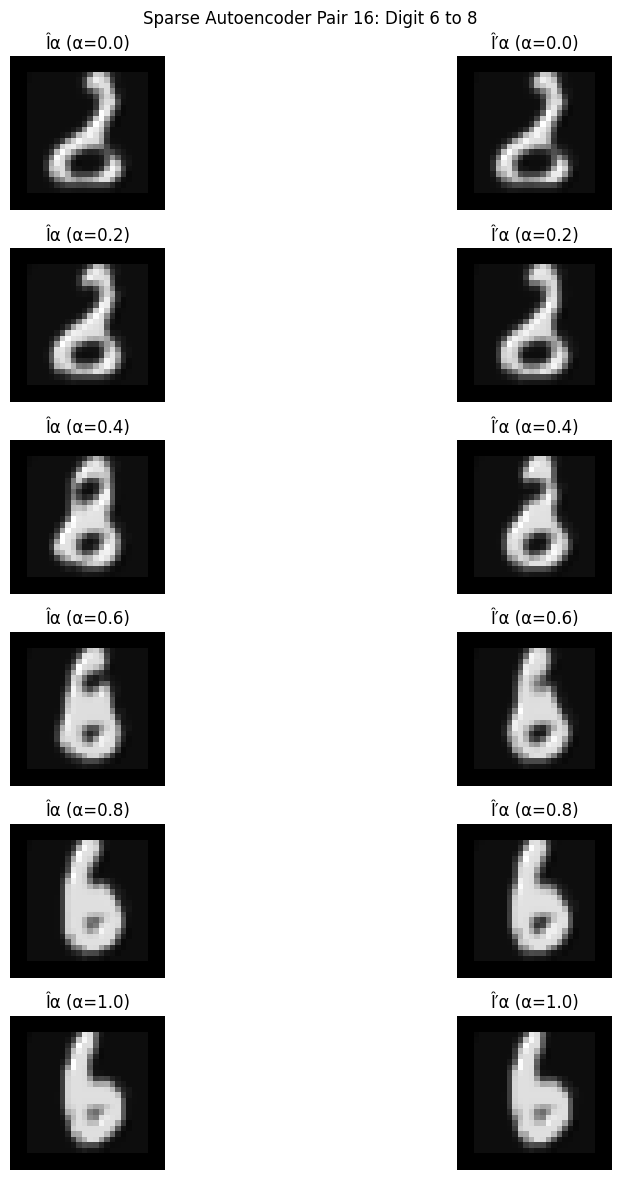

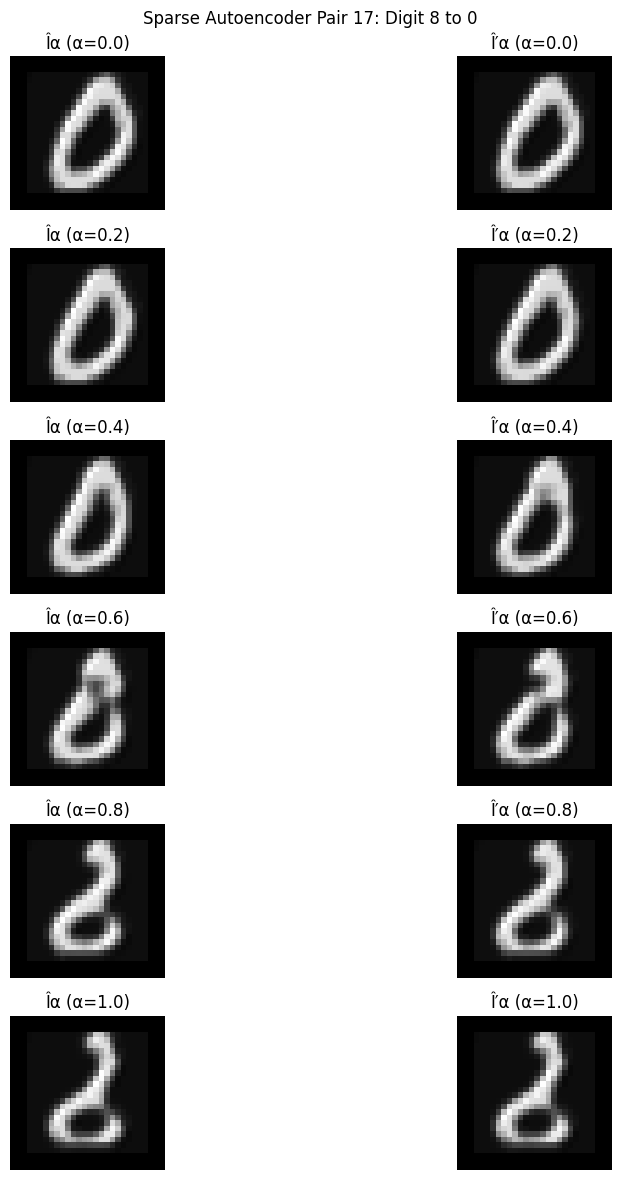

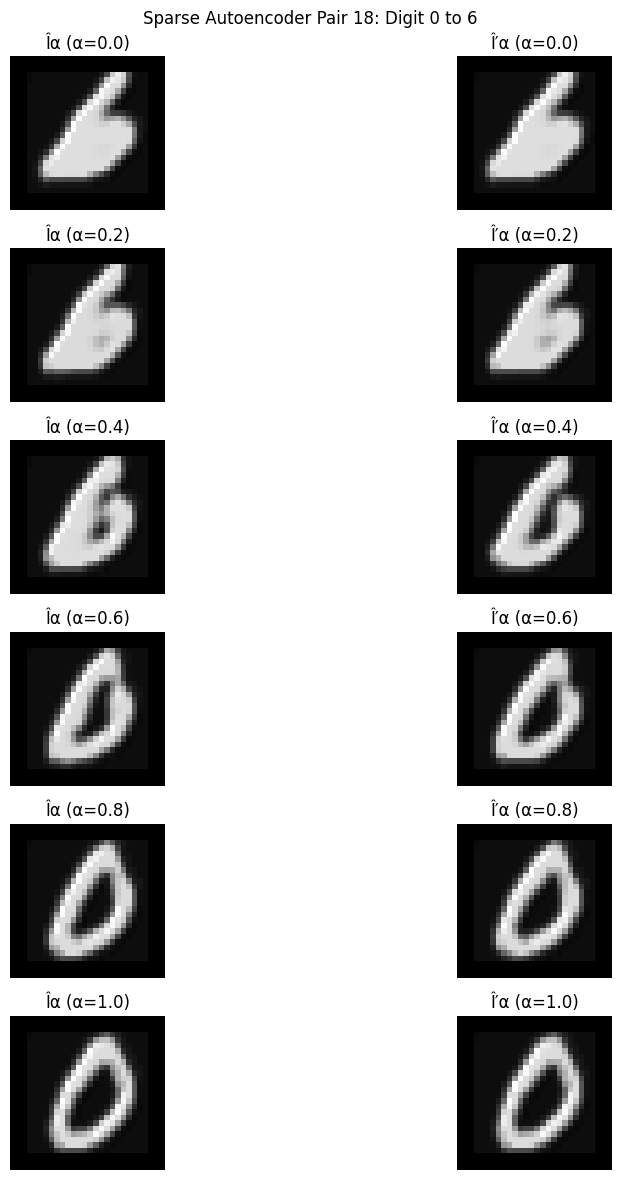

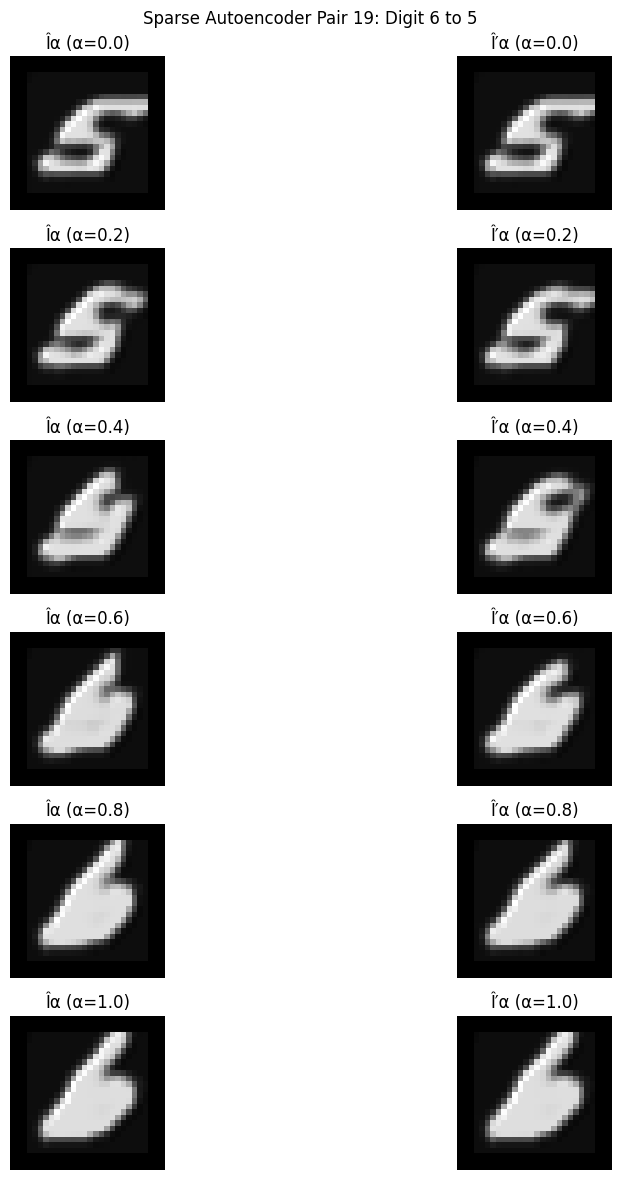

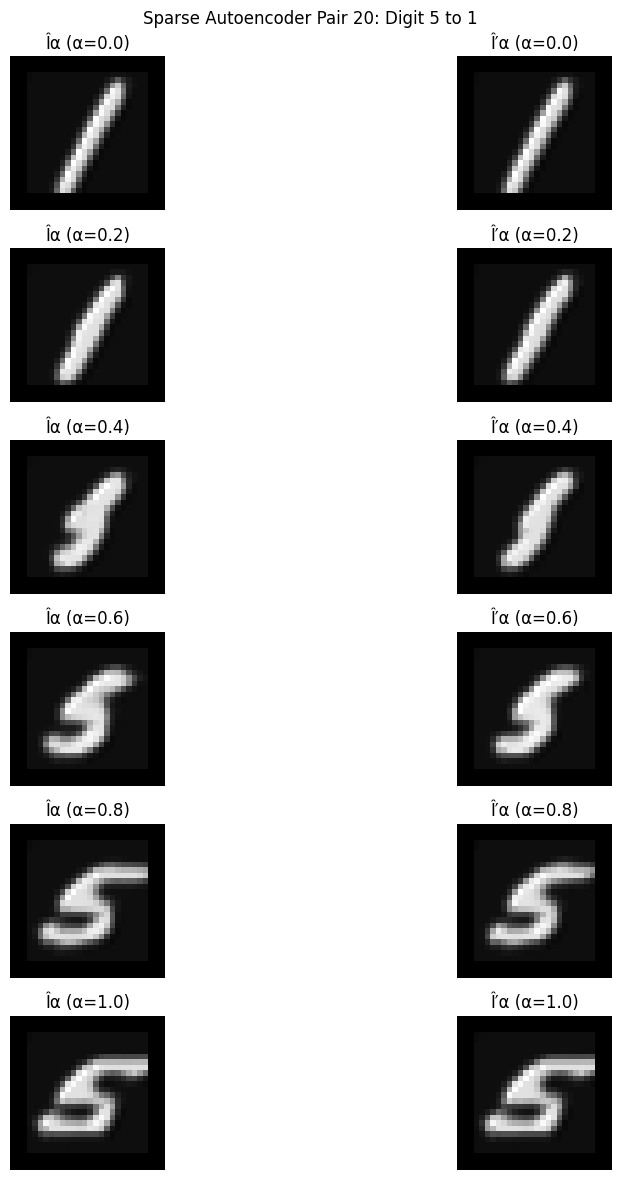


Sparse Autoencoder Metrics:
Alpha | Avg PSNR (dB) | Avg L2 Norm
------|---------------|------------
0.0  | inf      | 0.0000
0.2  | 31.8064      | 0.1674
0.4  | 25.4454      | 0.2600
0.6  | 25.9138      | 0.2602
0.8  | 31.3970      | 0.1680
1.0  | inf      | 0.0000


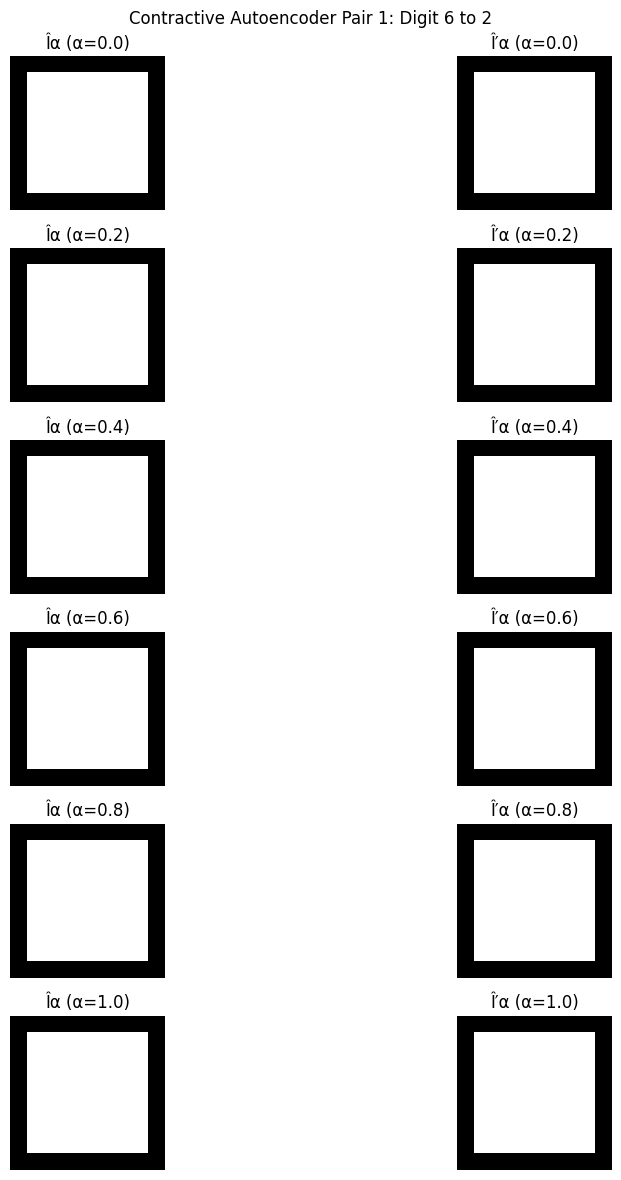

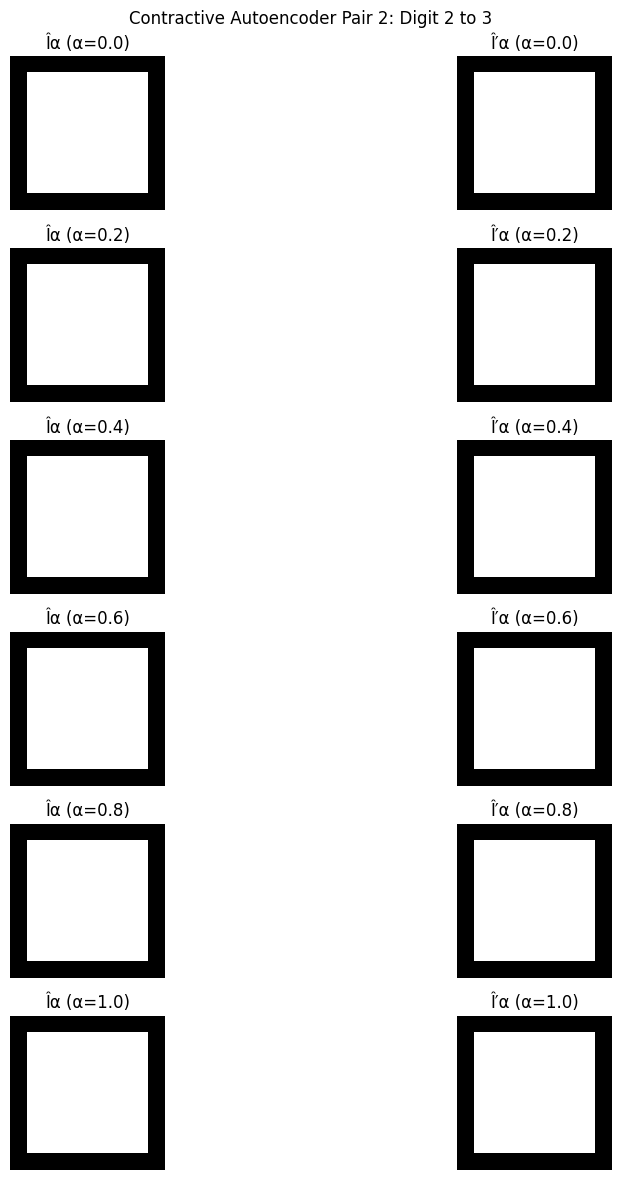

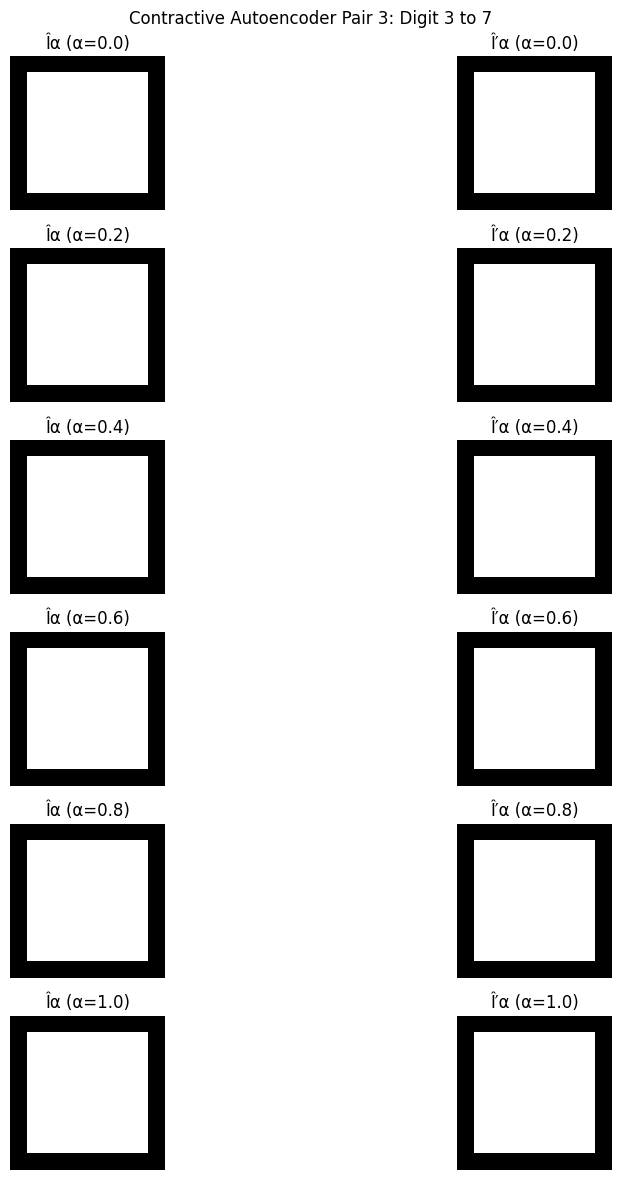

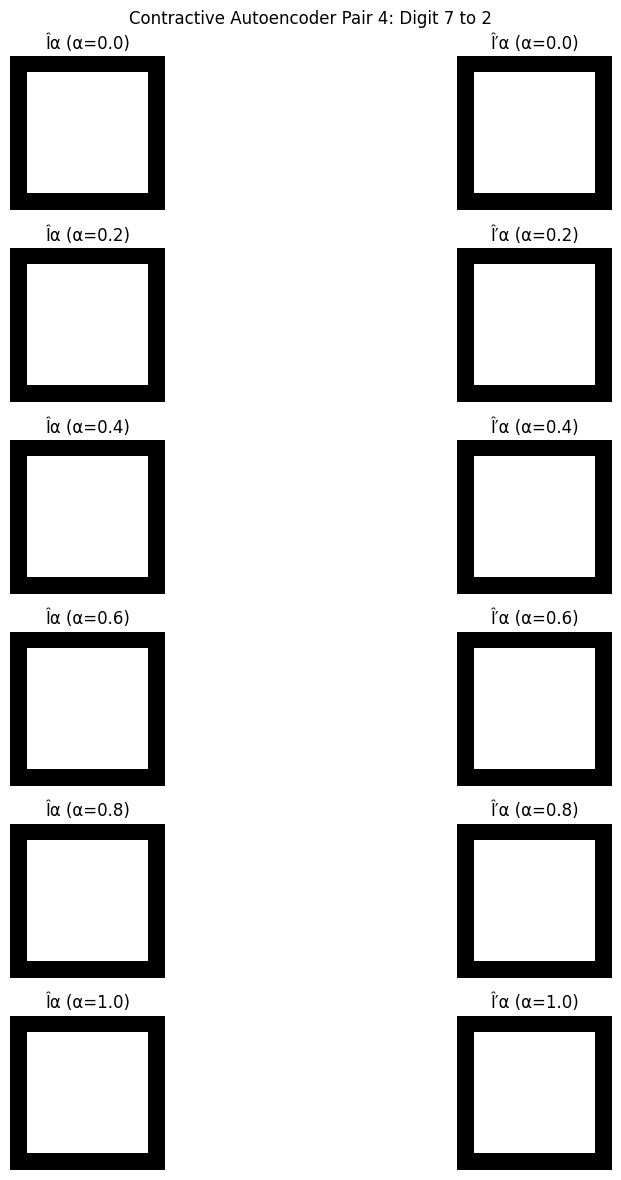

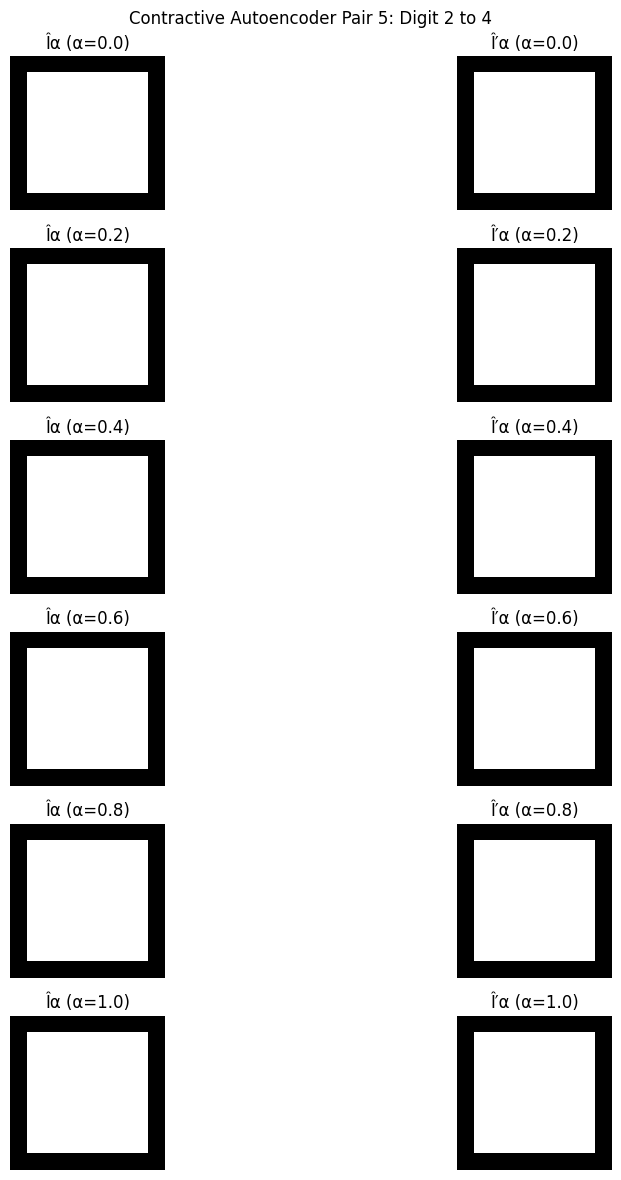

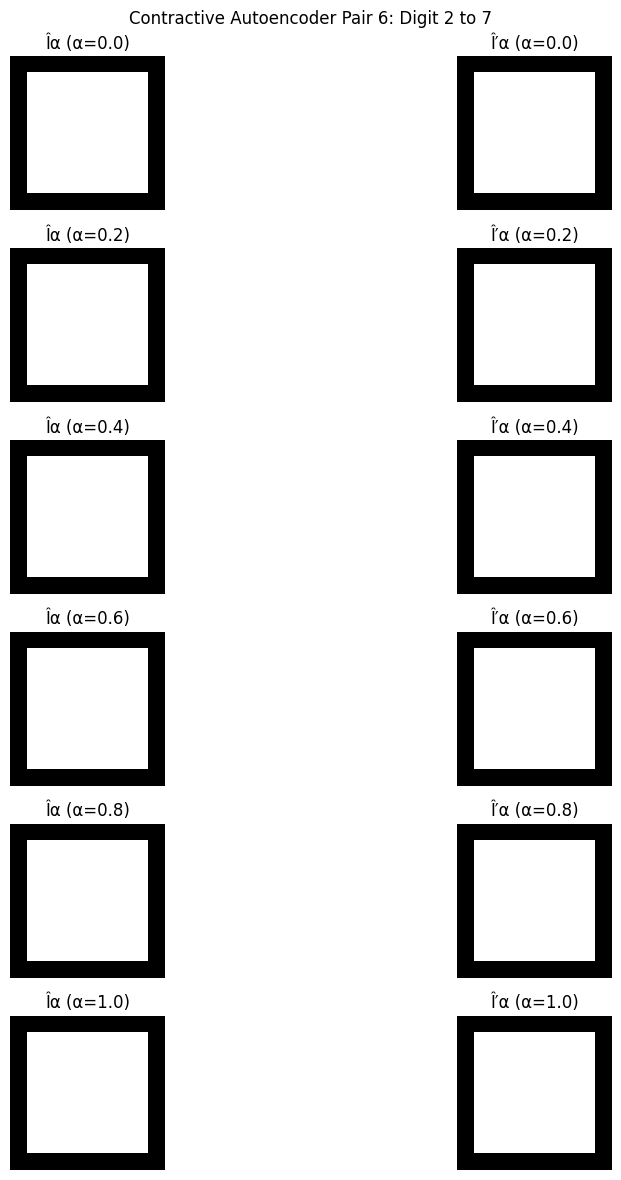

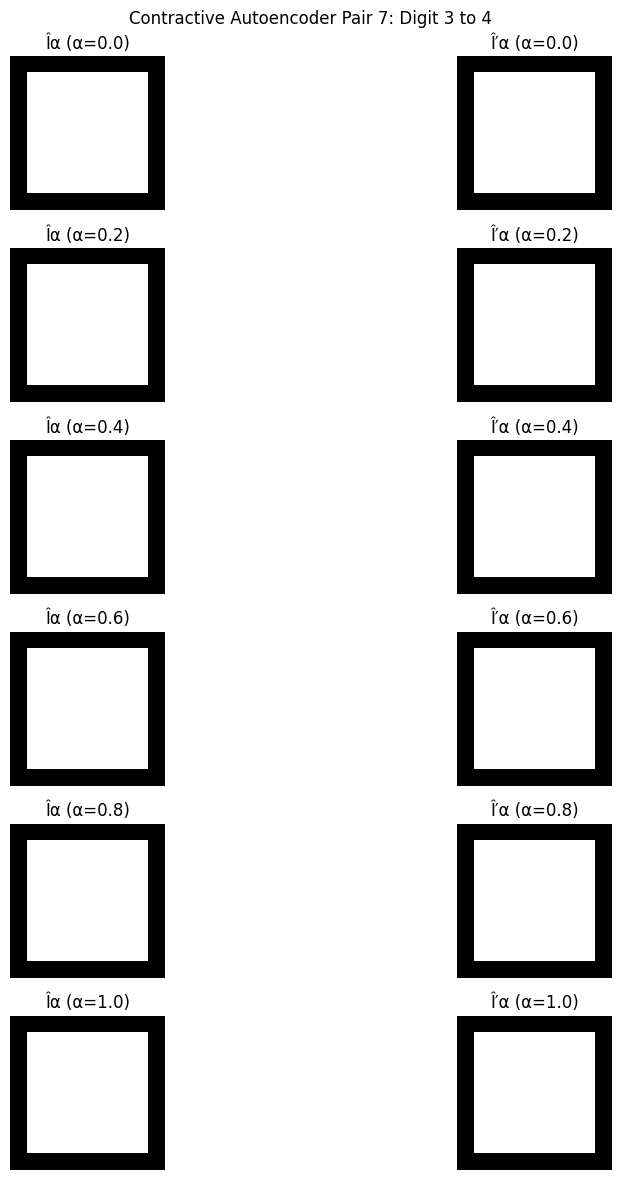

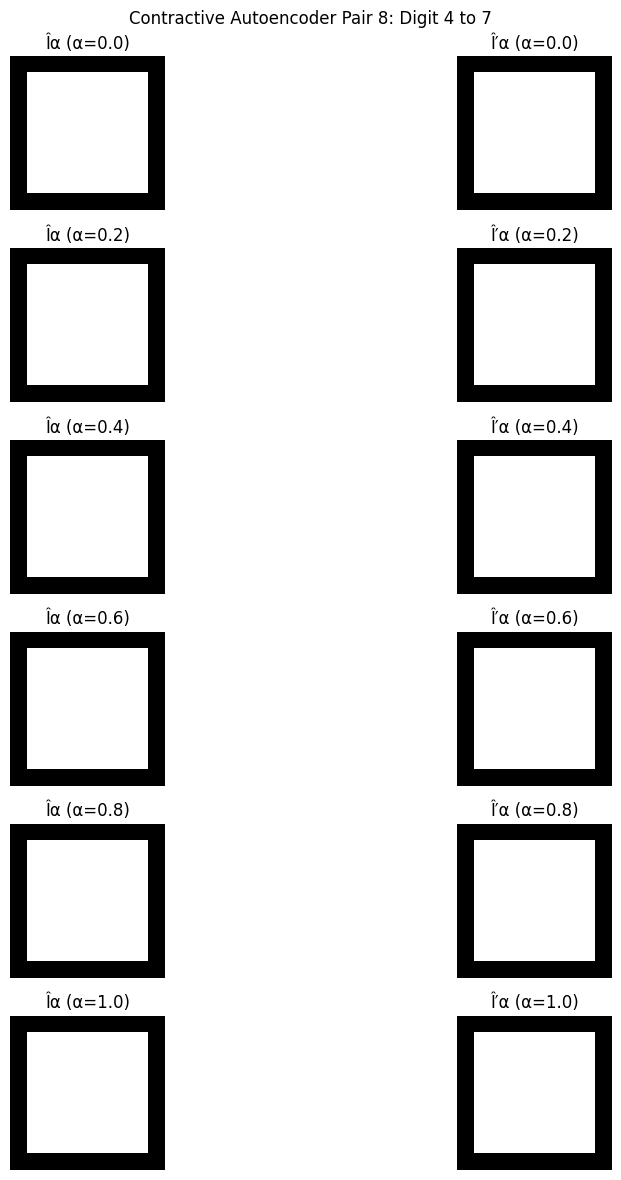

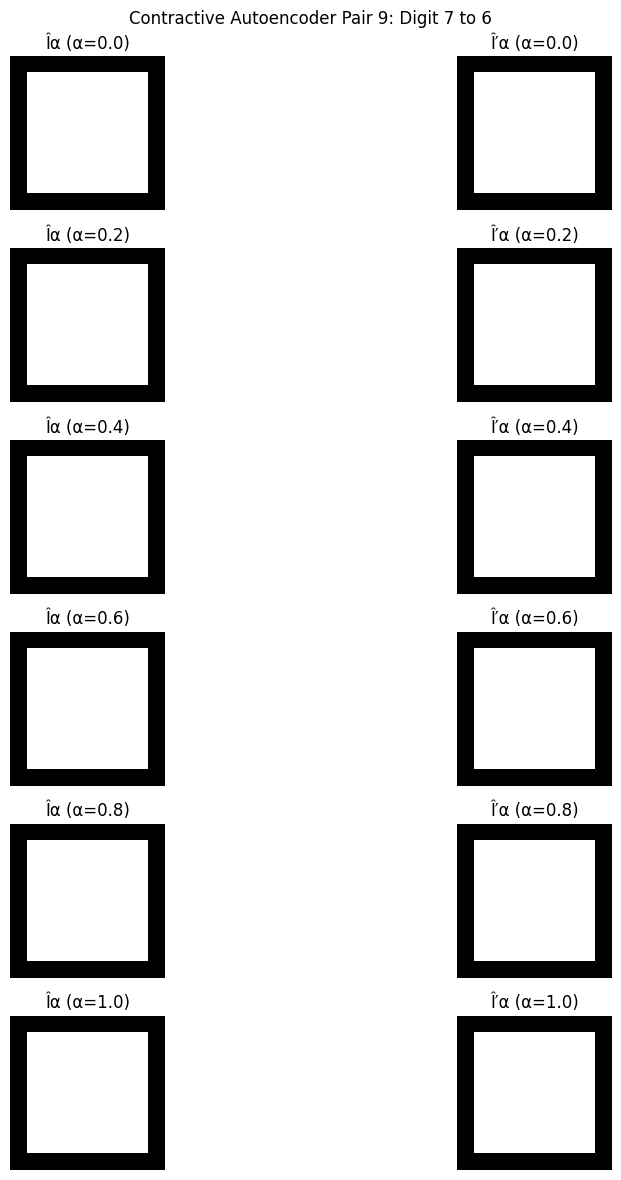

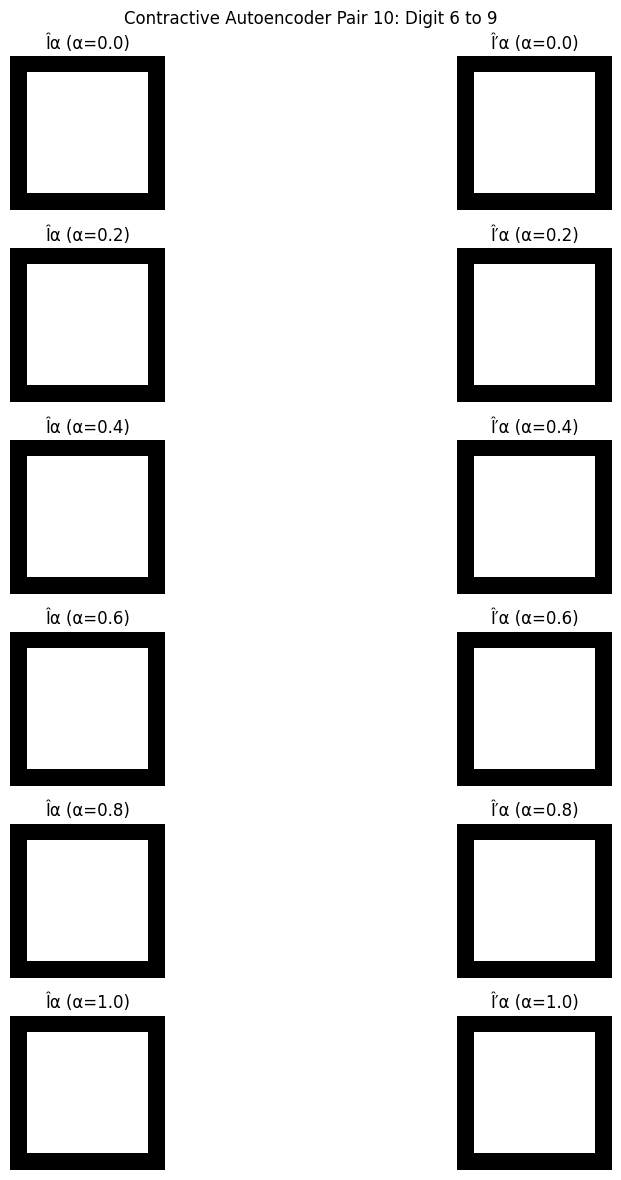

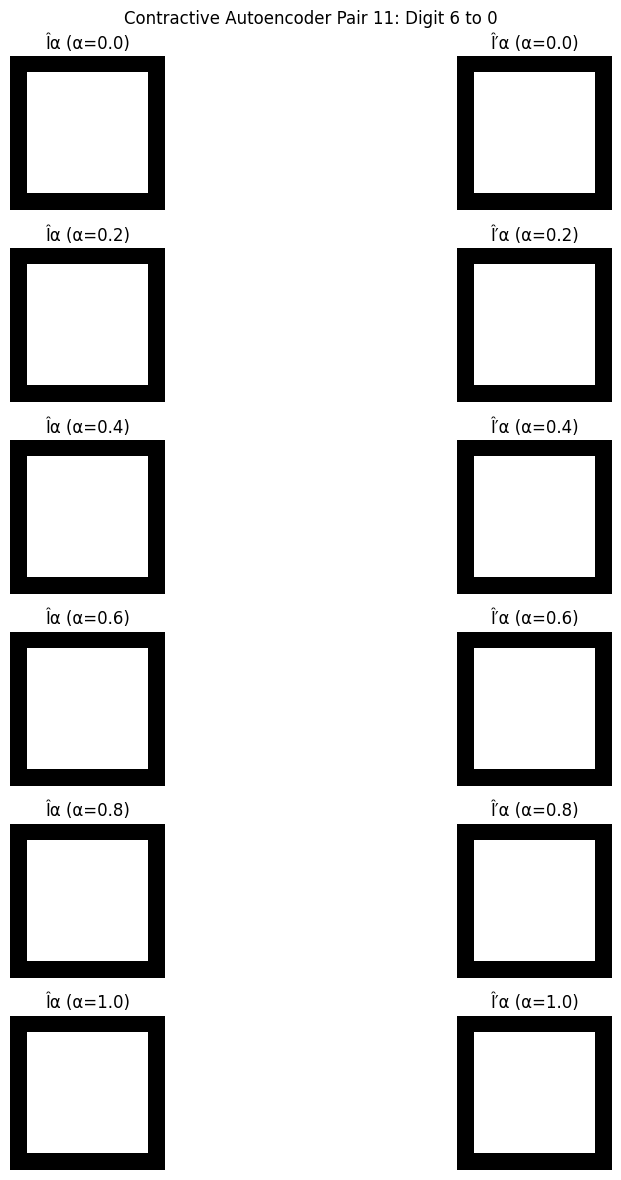

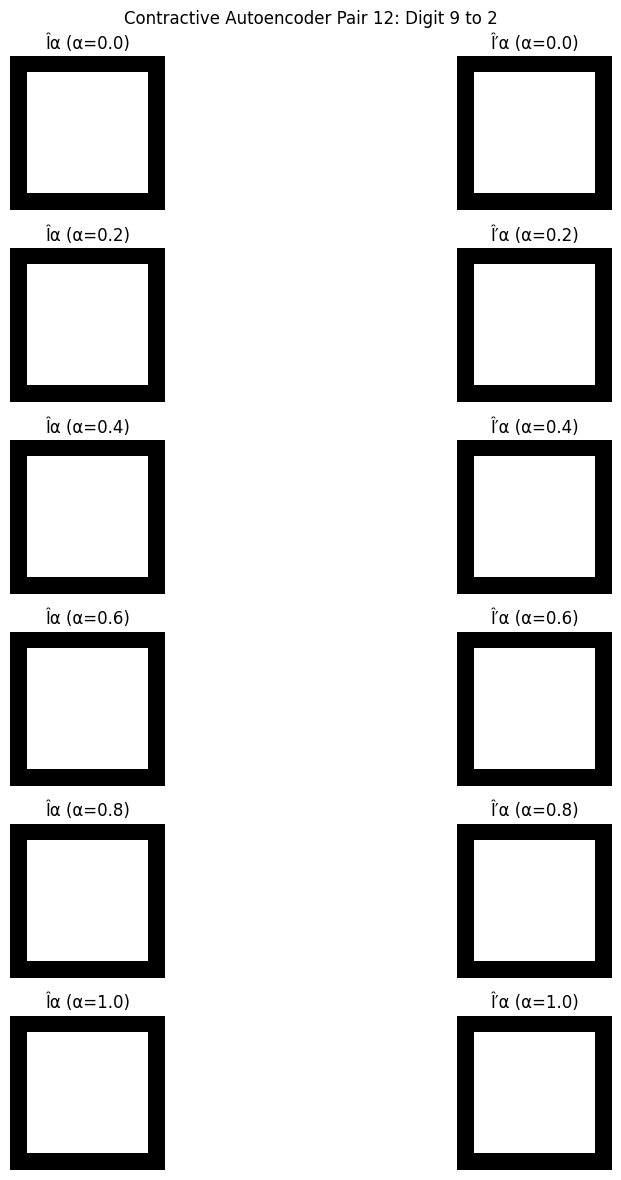

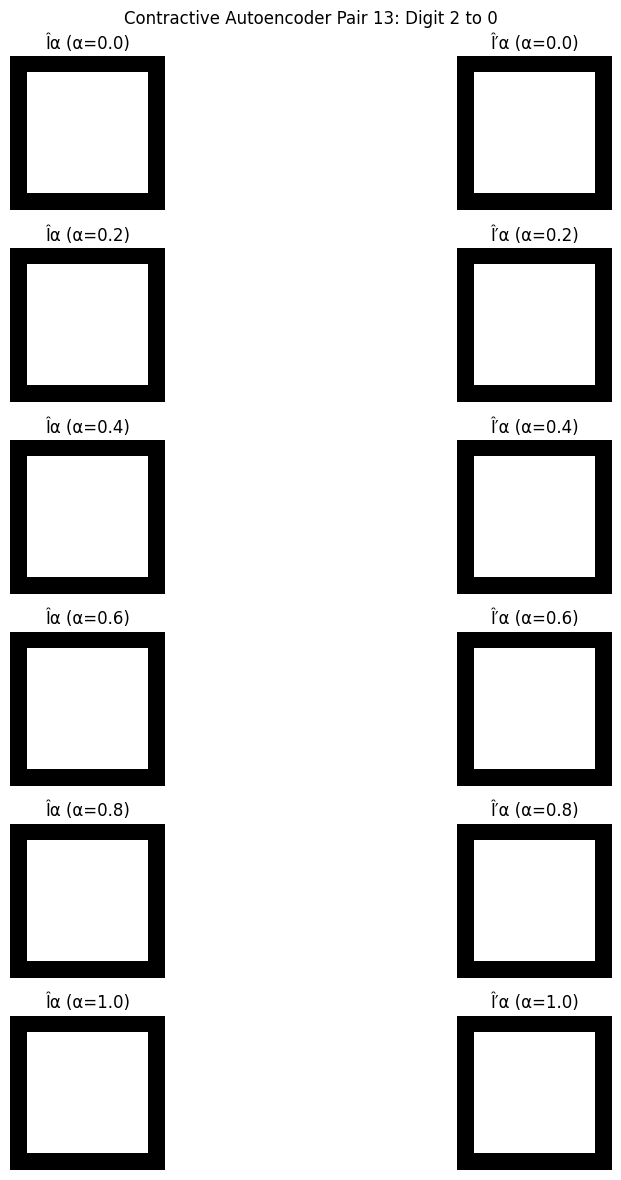

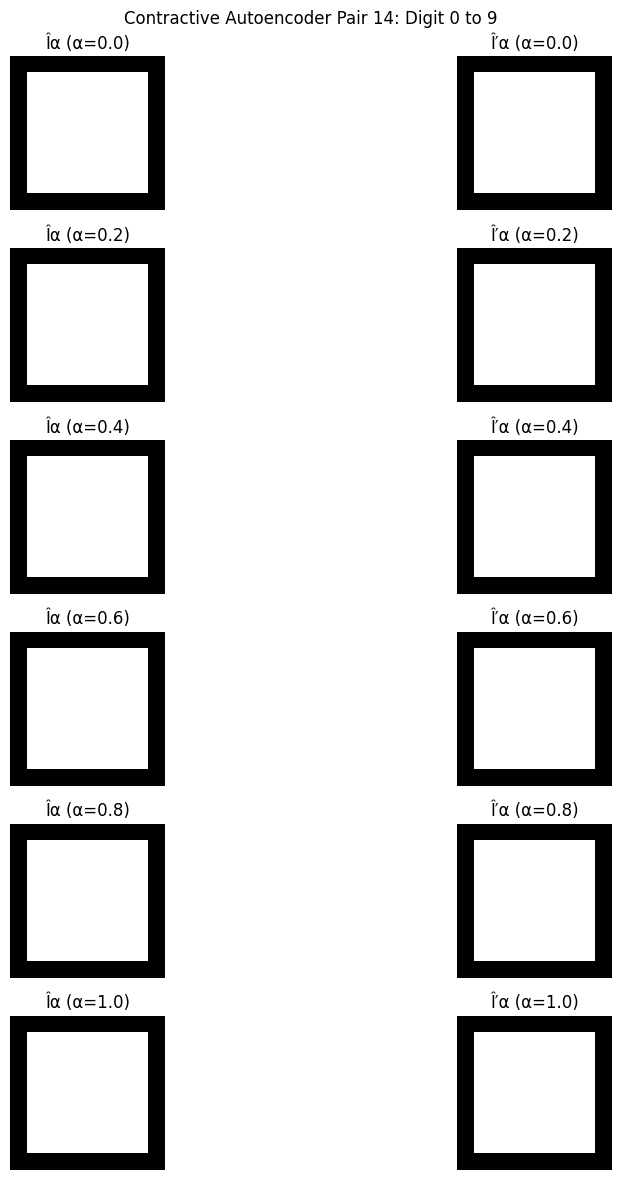

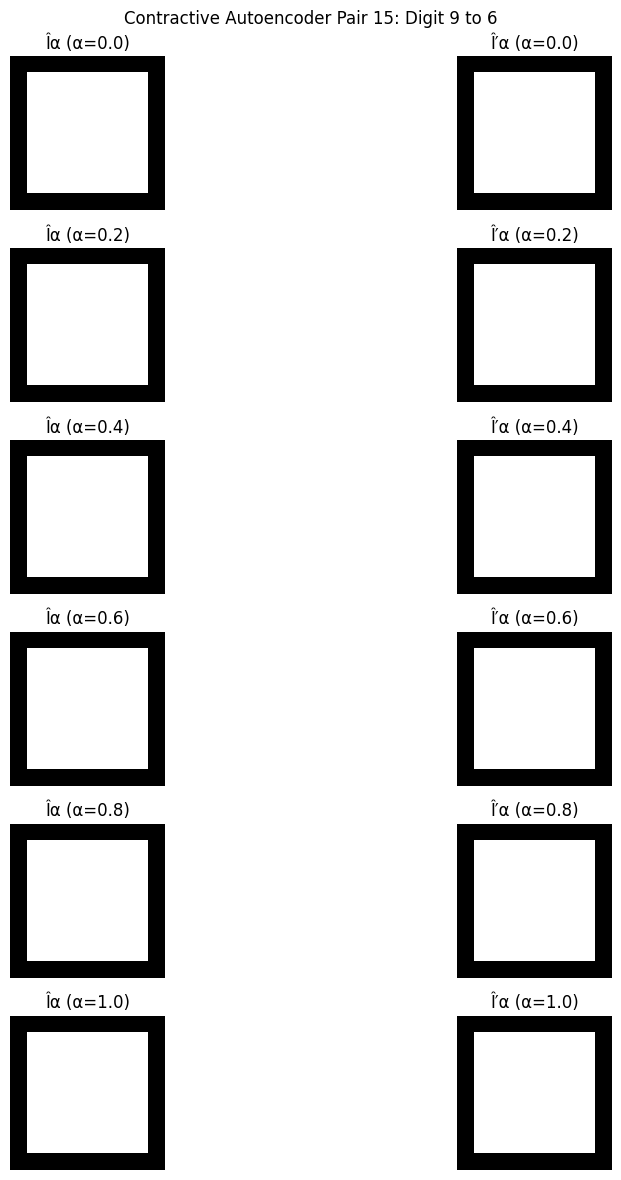

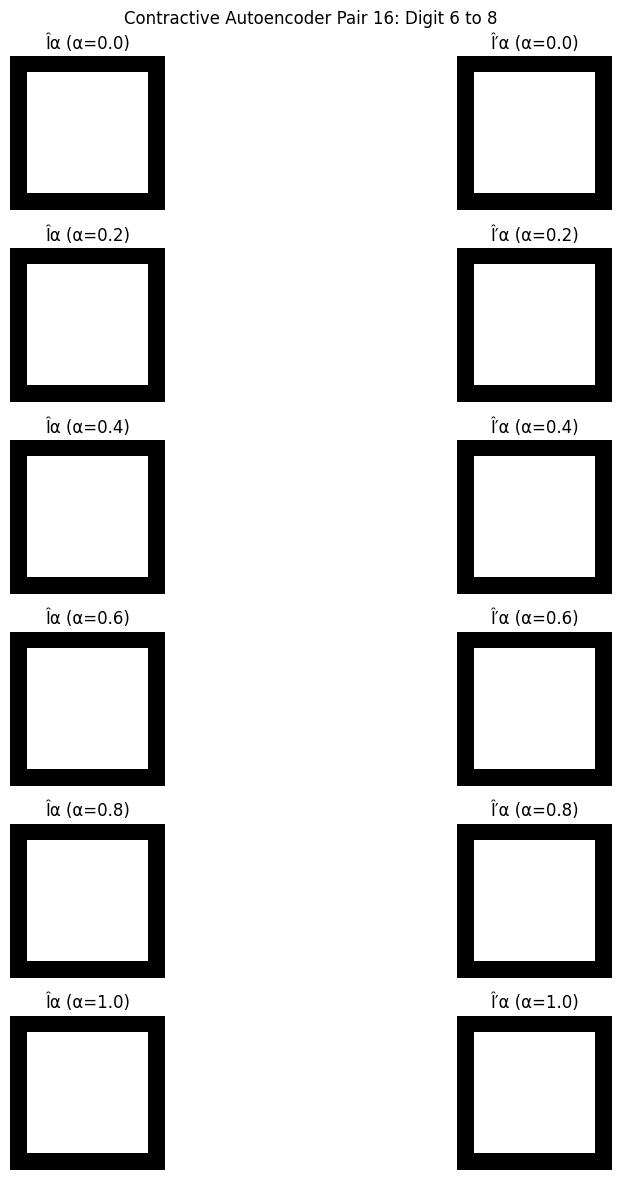

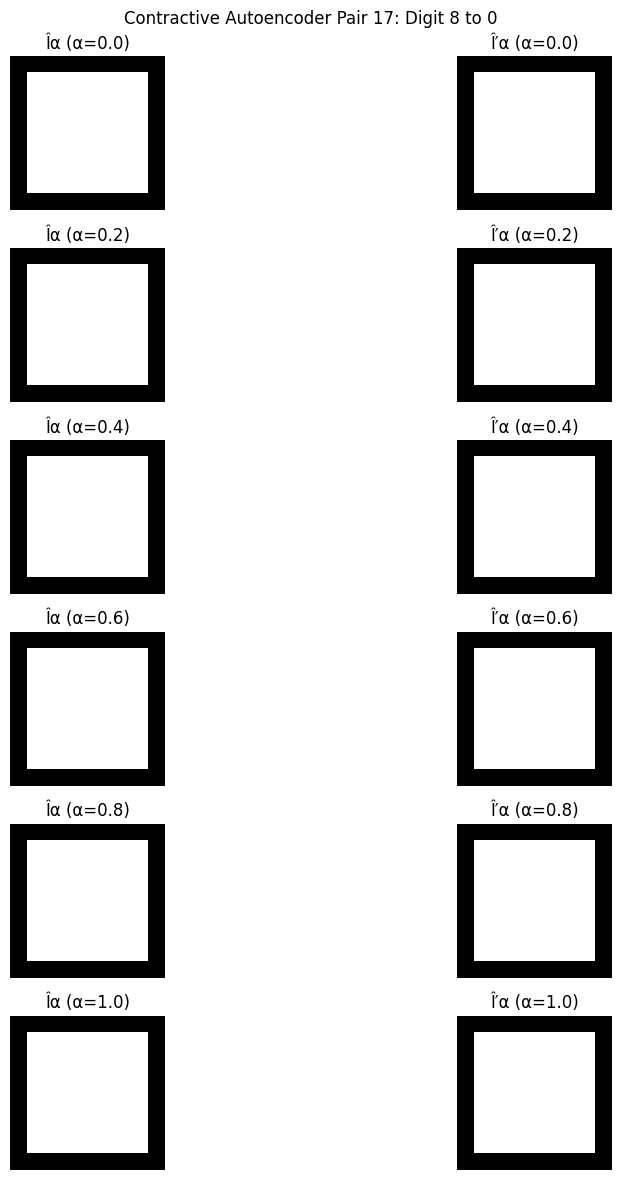

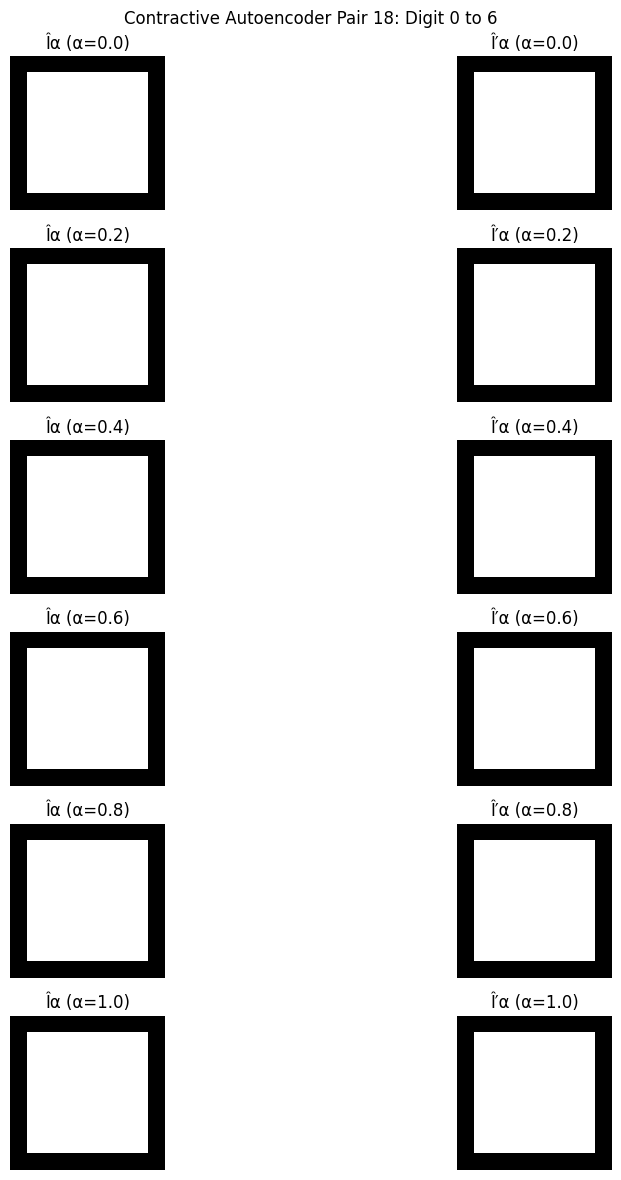

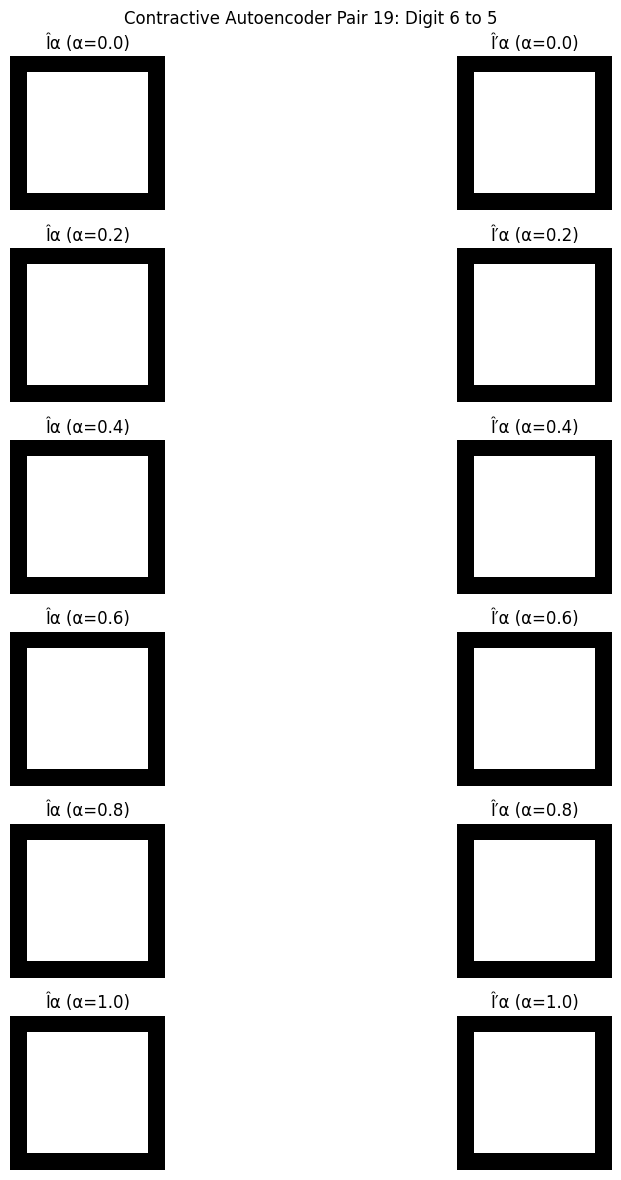

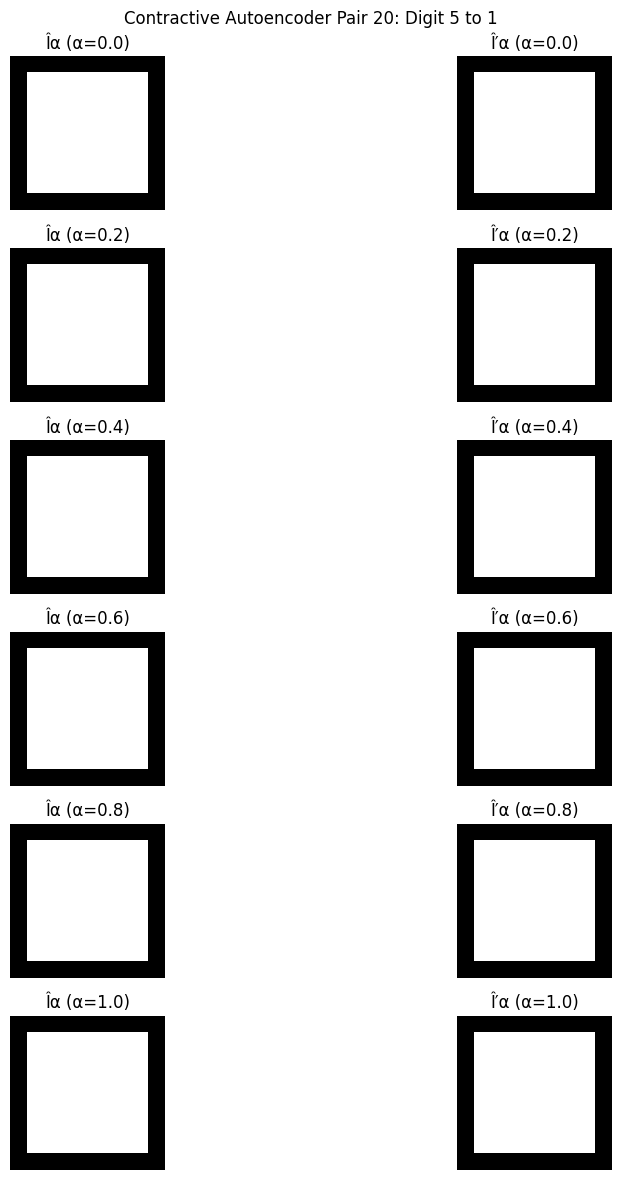


Contractive Autoencoder Metrics:
Alpha | Avg PSNR (dB) | Avg L2 Norm
------|---------------|------------
0.0  | inf      | 0.0000
0.2  | inf      | 94.8244
0.4  | inf      | 147.4840
0.6  | inf      | 147.4921
0.8  | inf      | 95.7696
1.0  | inf      | 0.0000


In [39]:
interpolation_analysis(sparse_ae, test_dataset, "Sparse Autoencoder")

interpolation_analysis(contractive_ae, test_dataset, "Contractive Autoencoder")

In [40]:

def classify_embeddings(model, train_data, train_labels, test_data, test_labels, model_name):
    train_embeddings = []
    for batch in tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size):
        z = model.encoder(batch, training=False).numpy()
        train_embeddings.append(z)
    train_embeddings = np.concatenate(train_embeddings, axis=0)

    test_embeddings = []
    for batch_images, batch_labels in test_data:
        z = model.encoder(batch_images, training=False).numpy()
        test_embeddings.append(z)
    test_embeddings = np.concatenate(test_embeddings, axis=0)

    test_labels_extracted = []
    for _, batch_labels in test_data:
        test_labels_extracted.append(batch_labels.numpy())
    test_labels_extracted = np.concatenate(test_labels_extracted, axis=0)

    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(train_embeddings, train_labels)

    test_predictions = classifier.predict(test_embeddings)
    accuracy = accuracy_score(test_labels_extracted, test_predictions)
    print(f"{model_name} Classification Accuracy: {accuracy:.4f}")

    return accuracy

In [41]:
print("\nClassifying Digits using Sparse Autoencoder Embeddings...")
sparse_accuracy = classify_embeddings(
    sparse_ae, x_train, y_train, test_dataset, y_test, "Sparse Autoencoder")

print("\nClassifying Digits using Contractive Autoencoder Embeddings...")
contractive_accuracy = classify_embeddings(contractive_ae, x_train, y_train, test_dataset, y_test,
                                           "Contractive Autoencoder")


Classifying Digits using Sparse Autoencoder Embeddings...
Sparse Autoencoder Classification Accuracy: 0.9593

Classifying Digits using Contractive Autoencoder Embeddings...
Contractive Autoencoder Classification Accuracy: 0.8393


e:\AI\ai-ml-course\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
print("\nComparison:")
if sparse_accuracy > contractive_accuracy:
    print(
        f"Sparse Autoencoder is better with accuracy {sparse_accuracy:.4f} vs. Contractive Autoencoder {contractive_accuracy:.4f}")
elif contractive_accuracy > sparse_accuracy:
    print(
        f"Contractive Autoencoder is better with accuracy {contractive_accuracy:.4f} vs. Sparse Autoencoder {sparse_accuracy:.4f}")
else:
    print(f"Both autoencoders have equal accuracy: {sparse_accuracy:.4f}")


Comparison:
Sparse Autoencoder is better with accuracy 0.9593 vs. Contractive Autoencoder 0.8393
